In [73]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import matplotlib.cm as cm

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [74]:
# Visualization for all models, used in the paper

In [75]:
plt.rcParams.update({'font.size': 18})

In [76]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))
    return model

In [77]:
train_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x.csv', index_col=0).to_numpy()
train_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

test_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x_test.csv', index_col=0).to_numpy()
test_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y_test.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

In [80]:
train_x_reshaped = train_x.reshape(20,-1, train_x.shape[-1])
train_y_reshaped = train_y.reshape(20,-1, train_y.shape[-1])

gpr_model = GprModel.GprModel()
indices = np.random.choice(train_x_reshaped.shape[1], 400, replace=False)            
gpr_model.fit(np.vstack(train_x_reshaped[:,indices,:]), np.vstack(train_y_reshaped[:,indices,:].reshape(-1,1)))


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[2.84941927e+01 1.35164937e+00 1.00000000e-05]


In [81]:
predicted_means,_ = gpr_mdoel.predict(test_x, test_y)

Root Mean Squared Error: 7.2472898043499745


In [82]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x, train_y = shuffle(train_x, train_y)

In [83]:
linear_model = LinearRegression().fit(train_x, train_y)

In [11]:
# neural_network_model = build_neural_network_model()


# neural_network_model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.MeanSquaredError(),
#     metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]
# )

# history = neural_network_model.fit(
#     train_x, 
#     train_y, 
#     epochs=50, 
#     shuffle=True
# )

In [84]:
#neural_network_model.save("visualization_nn.keras")
neural_network_model = tf.keras.models.load_model("visualization_nn.keras")

In [85]:
# All stations in the dataset
stations_to_test = [
    'LETHBRIDGE CDA',                 
    'EDMONTON STONY PLAIN CS',        
    'CORONATION CLIMATE',             
    'STRATHMORE AGDM',                
    'LLOYDMINSTER',                  
    'MEDICINE HAT RCS',             
    'MILK RIVER',                     
    'CAMROSE',                     
    'BROOKS',                    
    'CLARESHOLM',           
    'ONEFOUR CDA',            
    'VEGREVILLE',             
    'ROCKY MTN HOUSE (AUT)',         
    'LACOMBE CDA 2',              
    'BANFF CS',                     
    'DRUMHELLER EAST',         
    'MEDICINE HAT',                 
    'LETHBRIDGE',                 
    'EDMONTON INTL A',         
    'CALGARY INTL A'
]

In [92]:
def plot_prediction_error(y, y_prediction, station_name, axis_limit, axis):
    
    rmse = np.round(mean_squared_error(y, y_prediction, squared=False),4)

#     axis.set_ylim(0,axis_limit)
#     axis.set_xlim(0,axis_limit)
#     axis.plot([0, axis_limit], [0, axis_limit], 'k--')
#     axis.plot(y, y_prediction, 'ro', alpha=.2, label=f"RMSE for {station_name} = {rmse}")
#     axis.legend(loc="upper left")
#     axis.set_title(f"True v.s. predicted wind speed for \n {station_name}", wrap=True)
    
    print(f"{station_name} = {rmse}")

In [90]:
def plot_side_by_side_prediction_error(y, nn_y_prediction, gpr_prediction, ts_prediction, station_name):
    axis_limit = np.max(np.array(y).flatten())
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10)) 
    
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    plot_prediction_error(y, nn_y_prediction, station_name +' with neural network', axis_limit, ax1)
    plot_prediction_error(y, gpr_prediction, station_name +' with GPR', axis_limit, ax2)    
    plot_prediction_error(y, ts_prediction, station_name +' with T-S', axis_limit, ax3)    
    
    plt.show()

In [87]:
# Train the TS model
ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8)
ts_model.fit(train_x,train_y)

FCM training RMSE: 6.451955371925227


(41.627728121314796, 6.451955371925227, 64.05707955360413)

In [88]:
station = 'LETHBRIDGE CDA'
x = pd.read_csv(f'Data/visualization_data/{station}_x.csv', index_col=0).to_numpy()
y = pd.read_csv(f'Data/visualization_data/{station}_y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)
gpr_prediction_means,_ = gpr_mdoel.predict(scaler.inverse_transform(x), y)
gpr_prediction = []
for gpr_prediction_means_i in gpr_prediction_means:
    gpr_prediction = np.concatenate((gpr_prediction, gpr_prediction_means_i))
    
print(gpr_prediction.shape)

Root Mean Squared Error: 8.065069480569669
(26715,)


835/835 [==============================] - 1s 715us/step
Root Mean Squared Error: 8.065069480570285
(26715,)
(26715,)
RMSE for LETHBRIDGE CDA with neural network = 4.9302
RMSE for LETHBRIDGE CDA with GPR = 10.8078
RMSE for LETHBRIDGE CDA with T-S = 6.3293


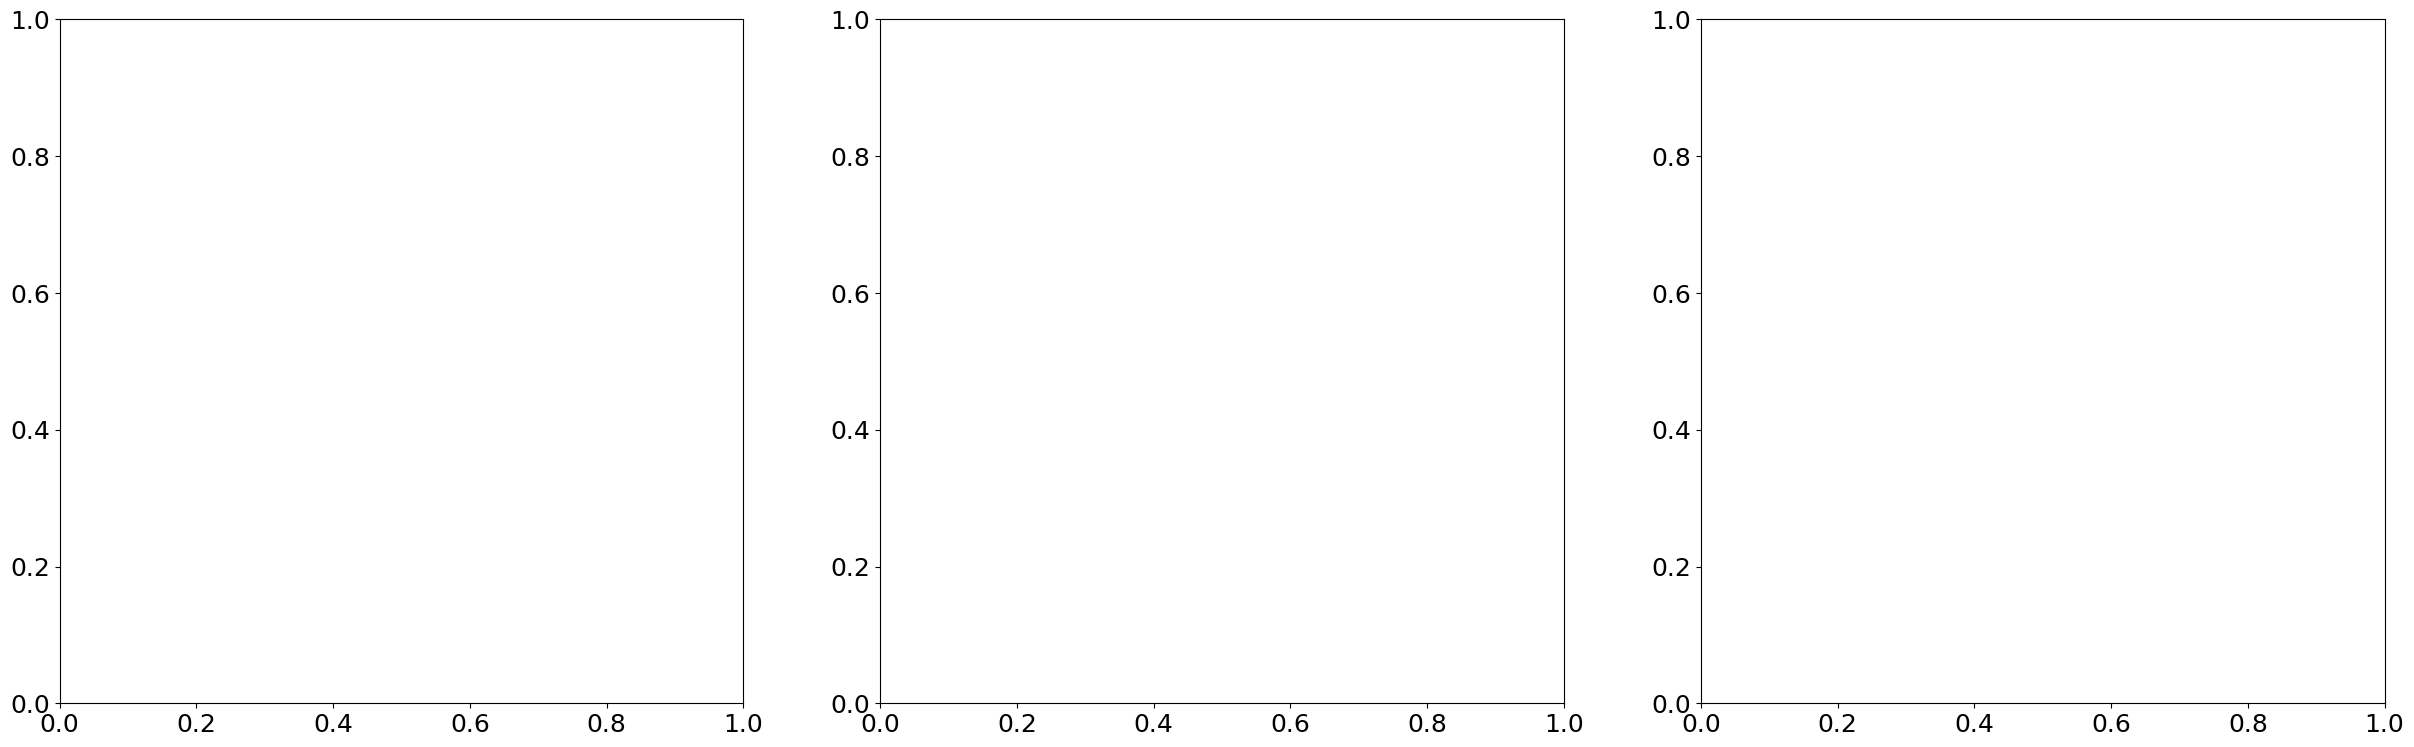

835/835 [==============================] - 0s 574us/step
Root Mean Squared Error: 6.30072390599829
(26715,)
(26715,)
RMSE for EDMONTON STONY PLAIN CS with neural network = 3.7462
RMSE for EDMONTON STONY PLAIN CS with GPR = 7.3046
RMSE for EDMONTON STONY PLAIN CS with T-S = 4.767


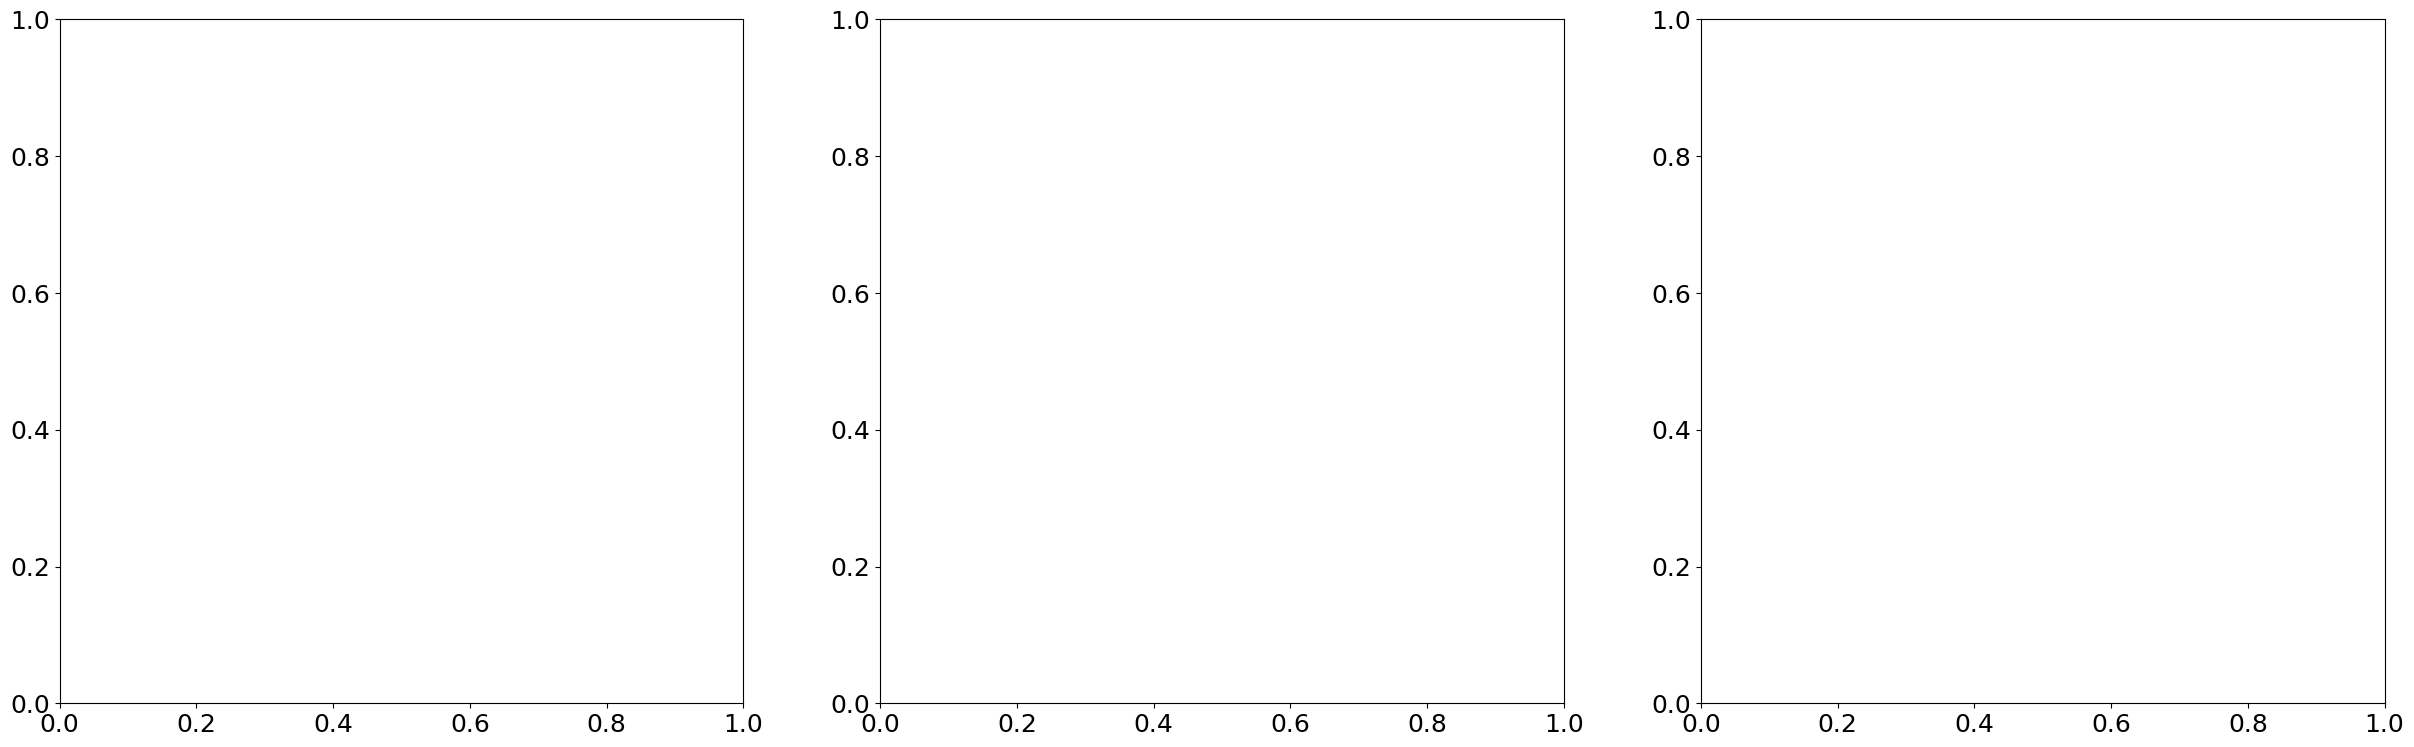

835/835 [==============================] - 0s 550us/step
Root Mean Squared Error: 6.939085642068036
(26715,)
(26715,)
RMSE for CORONATION CLIMATE with neural network = 5.5419
RMSE for CORONATION CLIMATE with GPR = 9.1854
RMSE for CORONATION CLIMATE with T-S = 6.2447


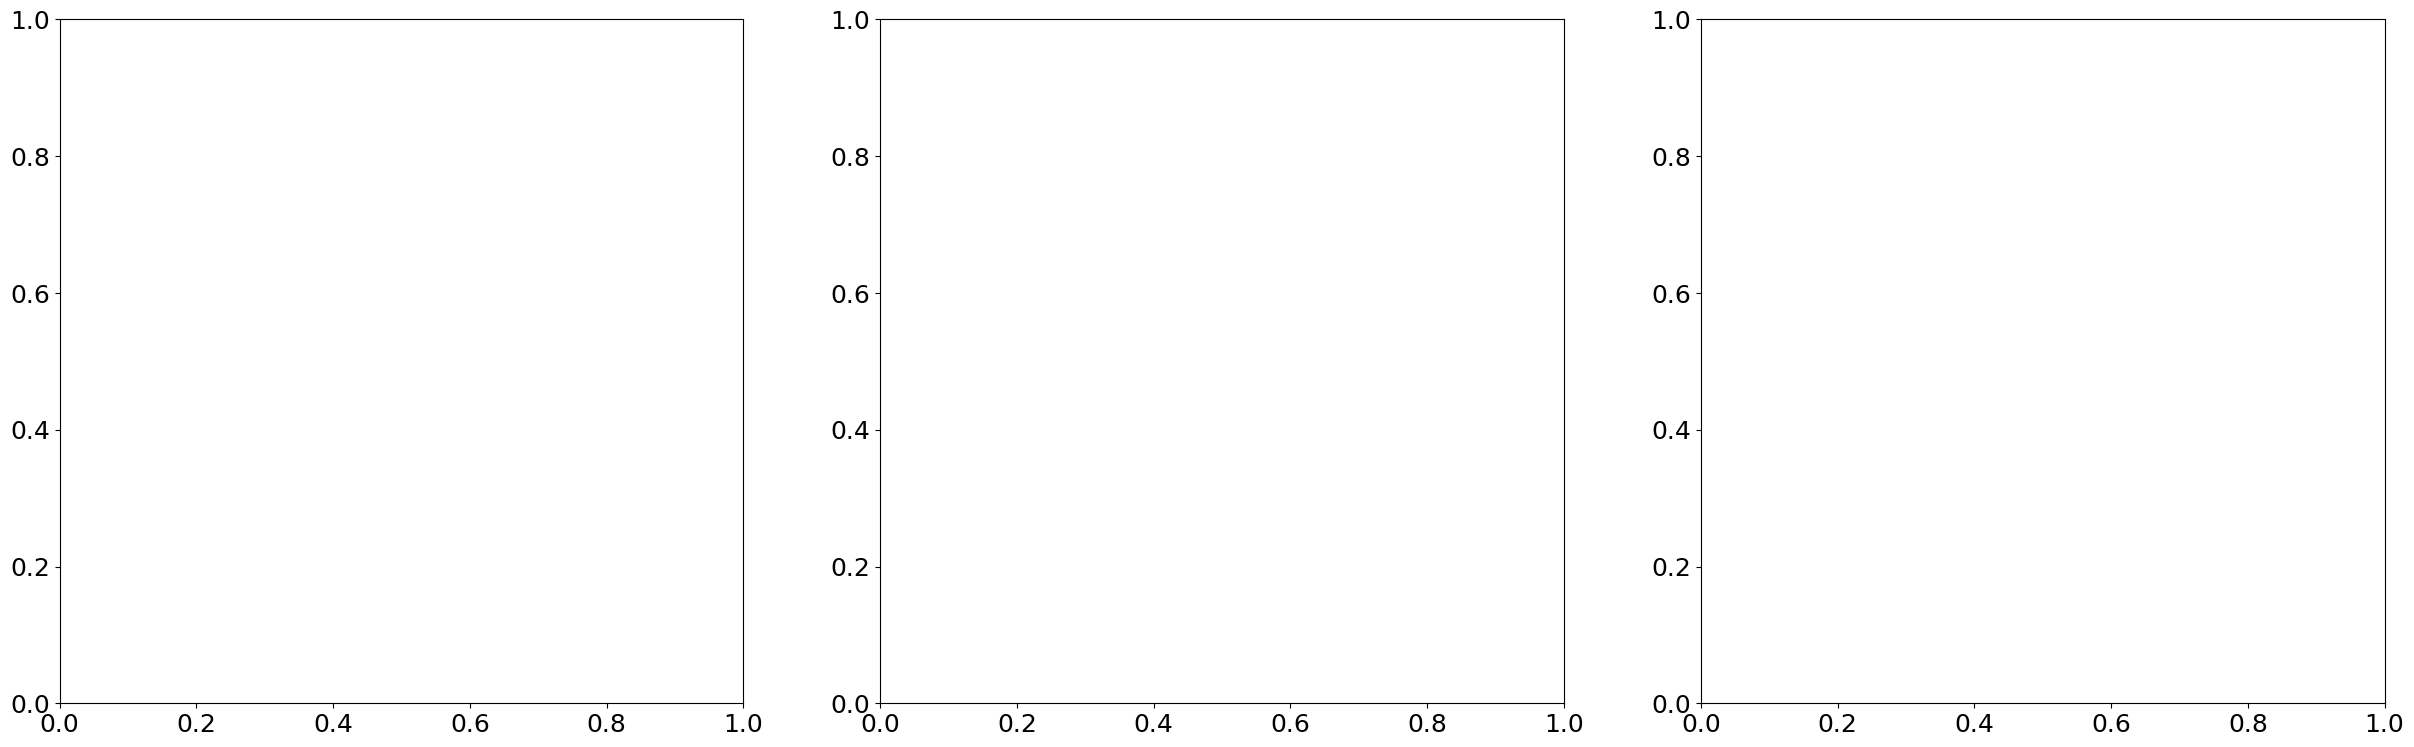

835/835 [==============================] - 1s 681us/step
Root Mean Squared Error: 6.351133215445169
(26715,)
(26715,)
RMSE for STRATHMORE AGDM with neural network = 5.3649
RMSE for STRATHMORE AGDM with GPR = 8.3457
RMSE for STRATHMORE AGDM with T-S = 6.2602


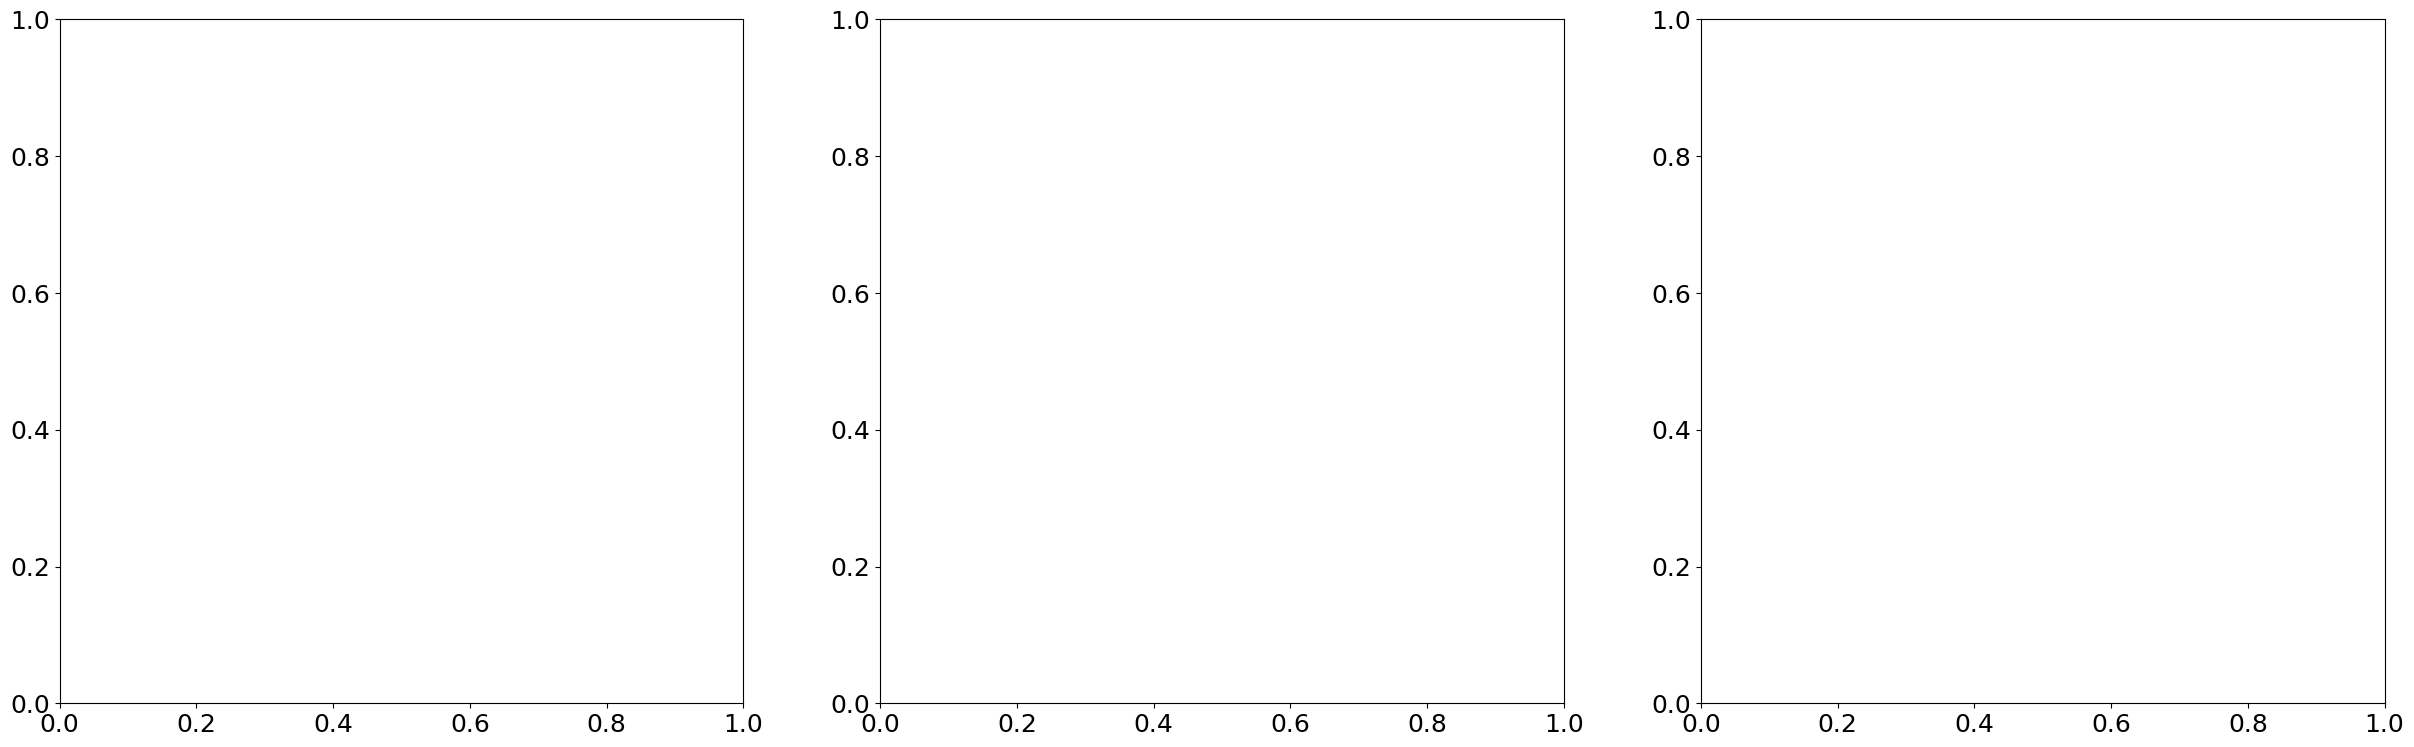

835/835 [==============================] - 0s 473us/step
Root Mean Squared Error: 6.57228843078736
(26715,)
(26715,)
RMSE for LLOYDMINSTER with neural network = 5.9256
RMSE for LLOYDMINSTER with GPR = 8.6239
RMSE for LLOYDMINSTER with T-S = 6.5574


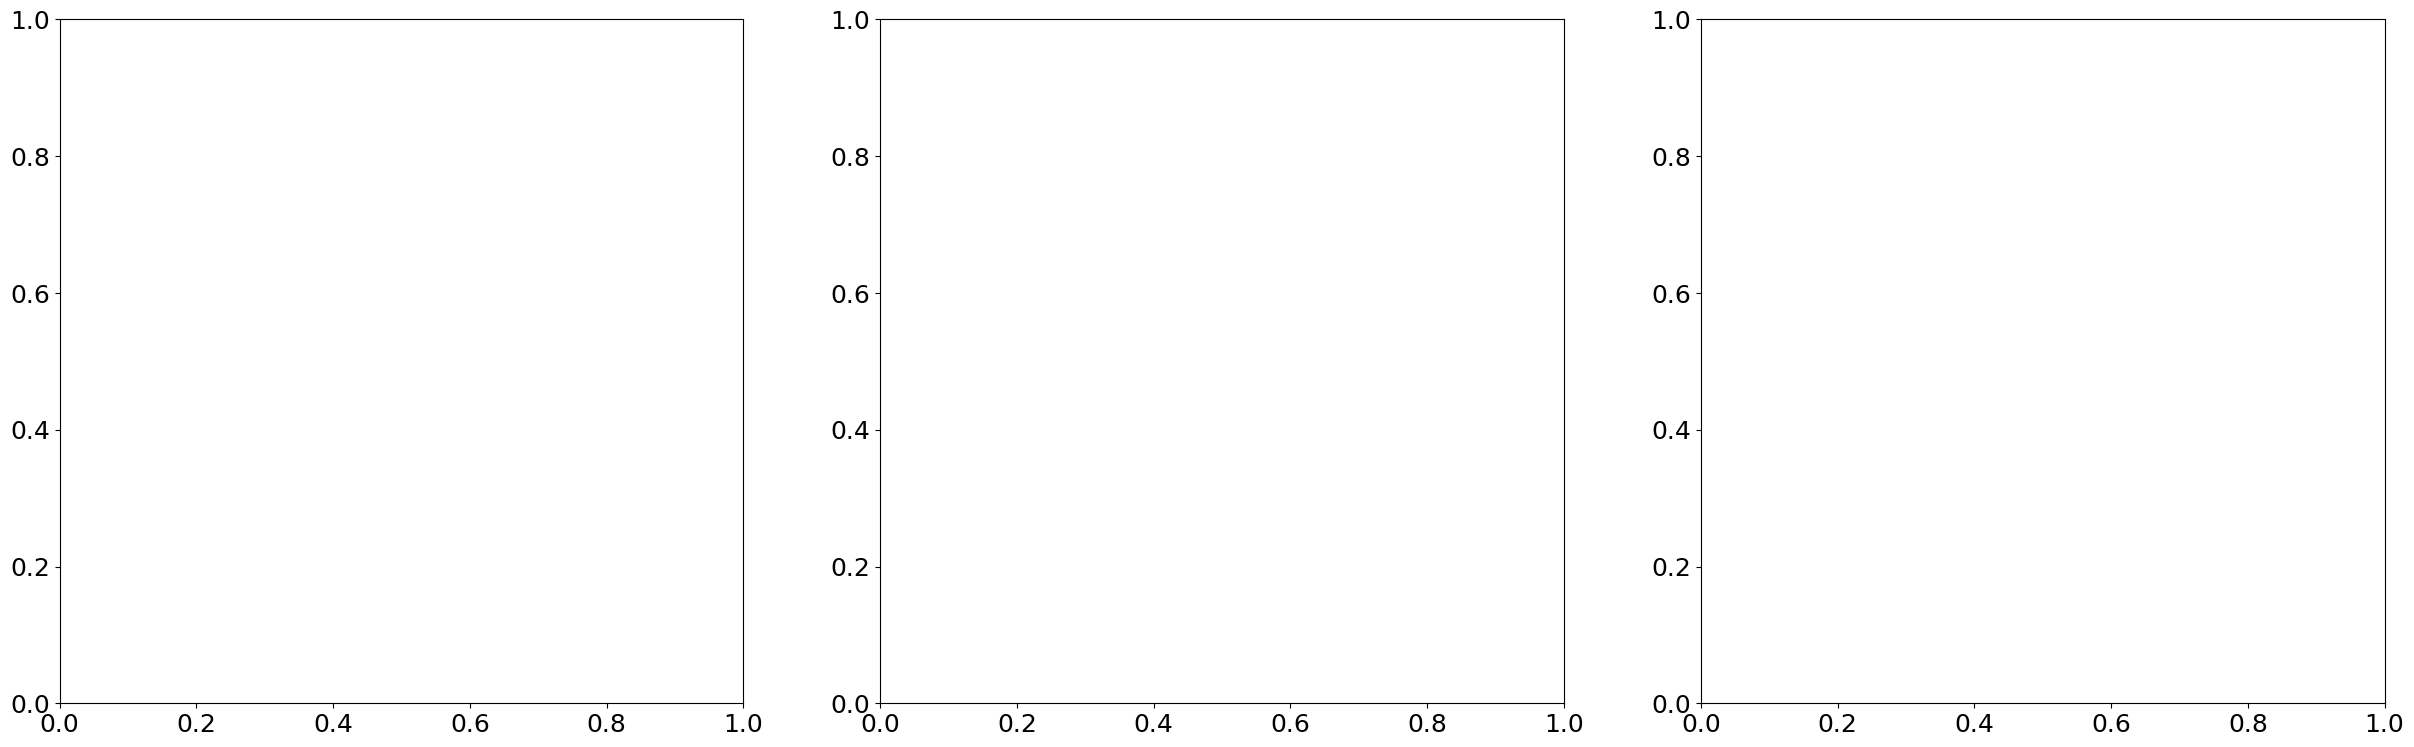

835/835 [==============================] - 1s 635us/step
Root Mean Squared Error: 6.417423856422836
(26715,)
(26715,)
RMSE for MEDICINE HAT RCS with neural network = 4.0921
RMSE for MEDICINE HAT RCS with GPR = 8.0156
RMSE for MEDICINE HAT RCS with T-S = 5.272


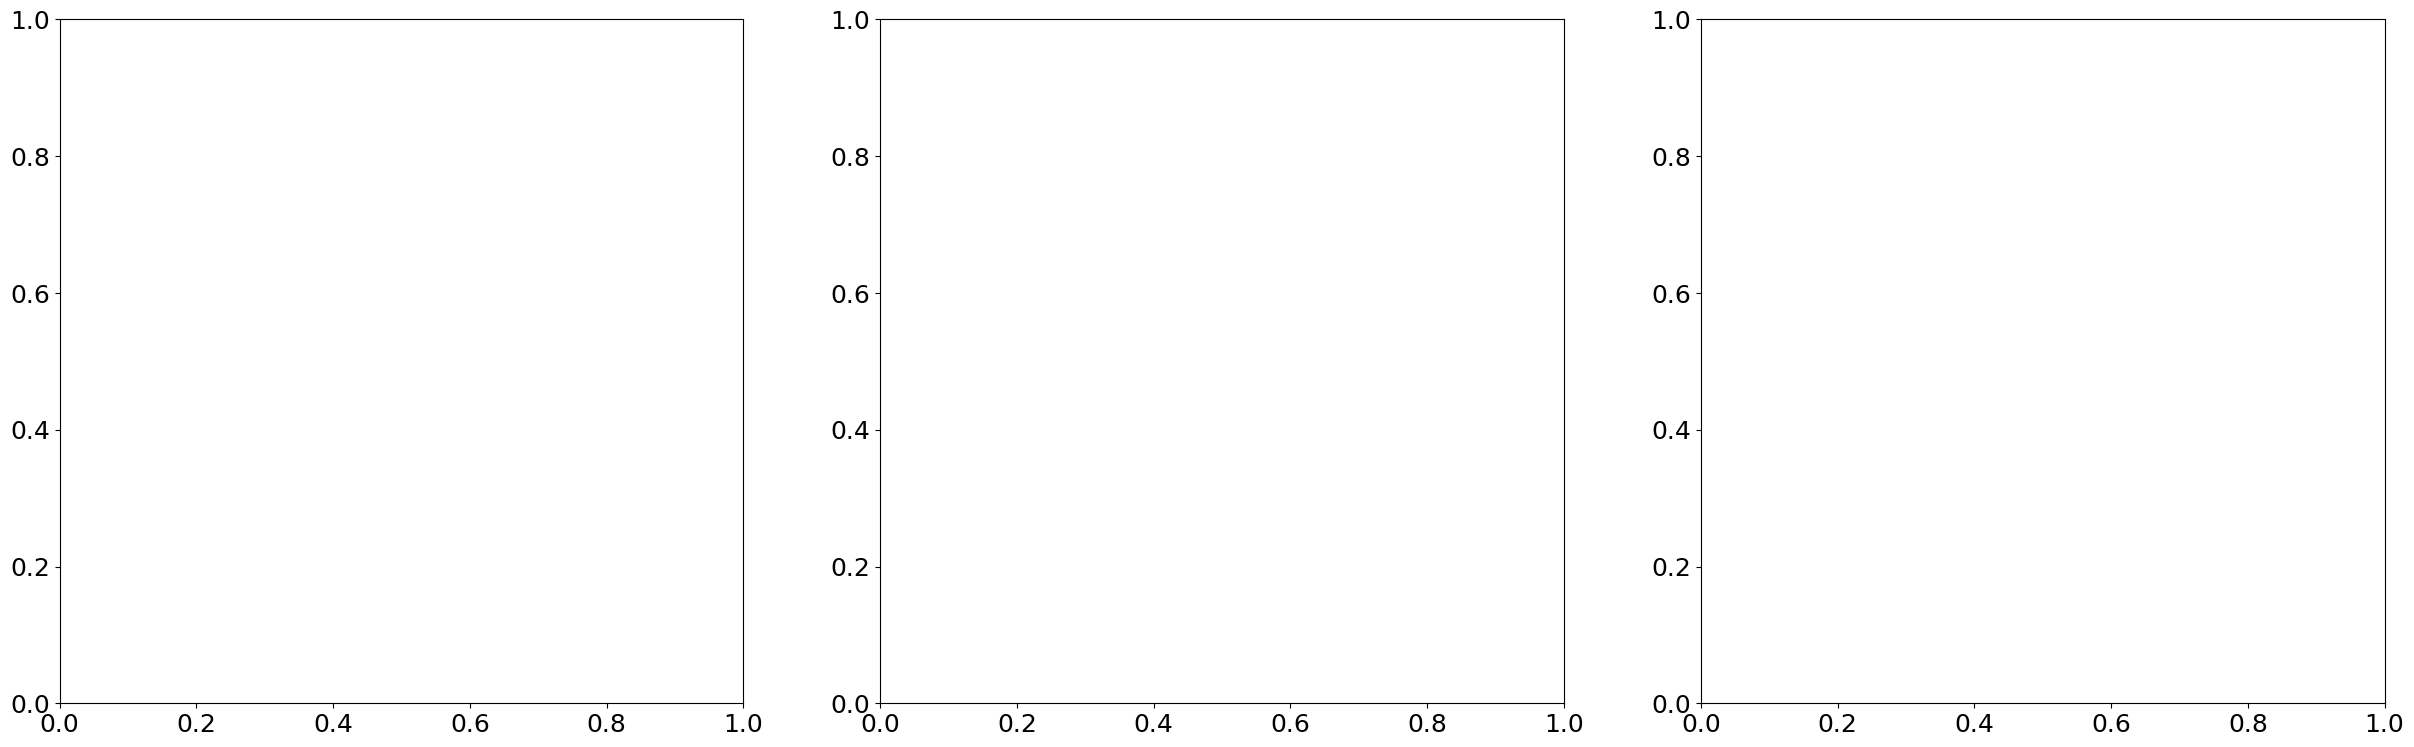

835/835 [==============================] - 1s 633us/step
Root Mean Squared Error: 8.498872932654201
(26715,)
(26715,)
RMSE for MILK RIVER with neural network = 7.1068
RMSE for MILK RIVER with GPR = 11.2643
RMSE for MILK RIVER with T-S = 7.6987


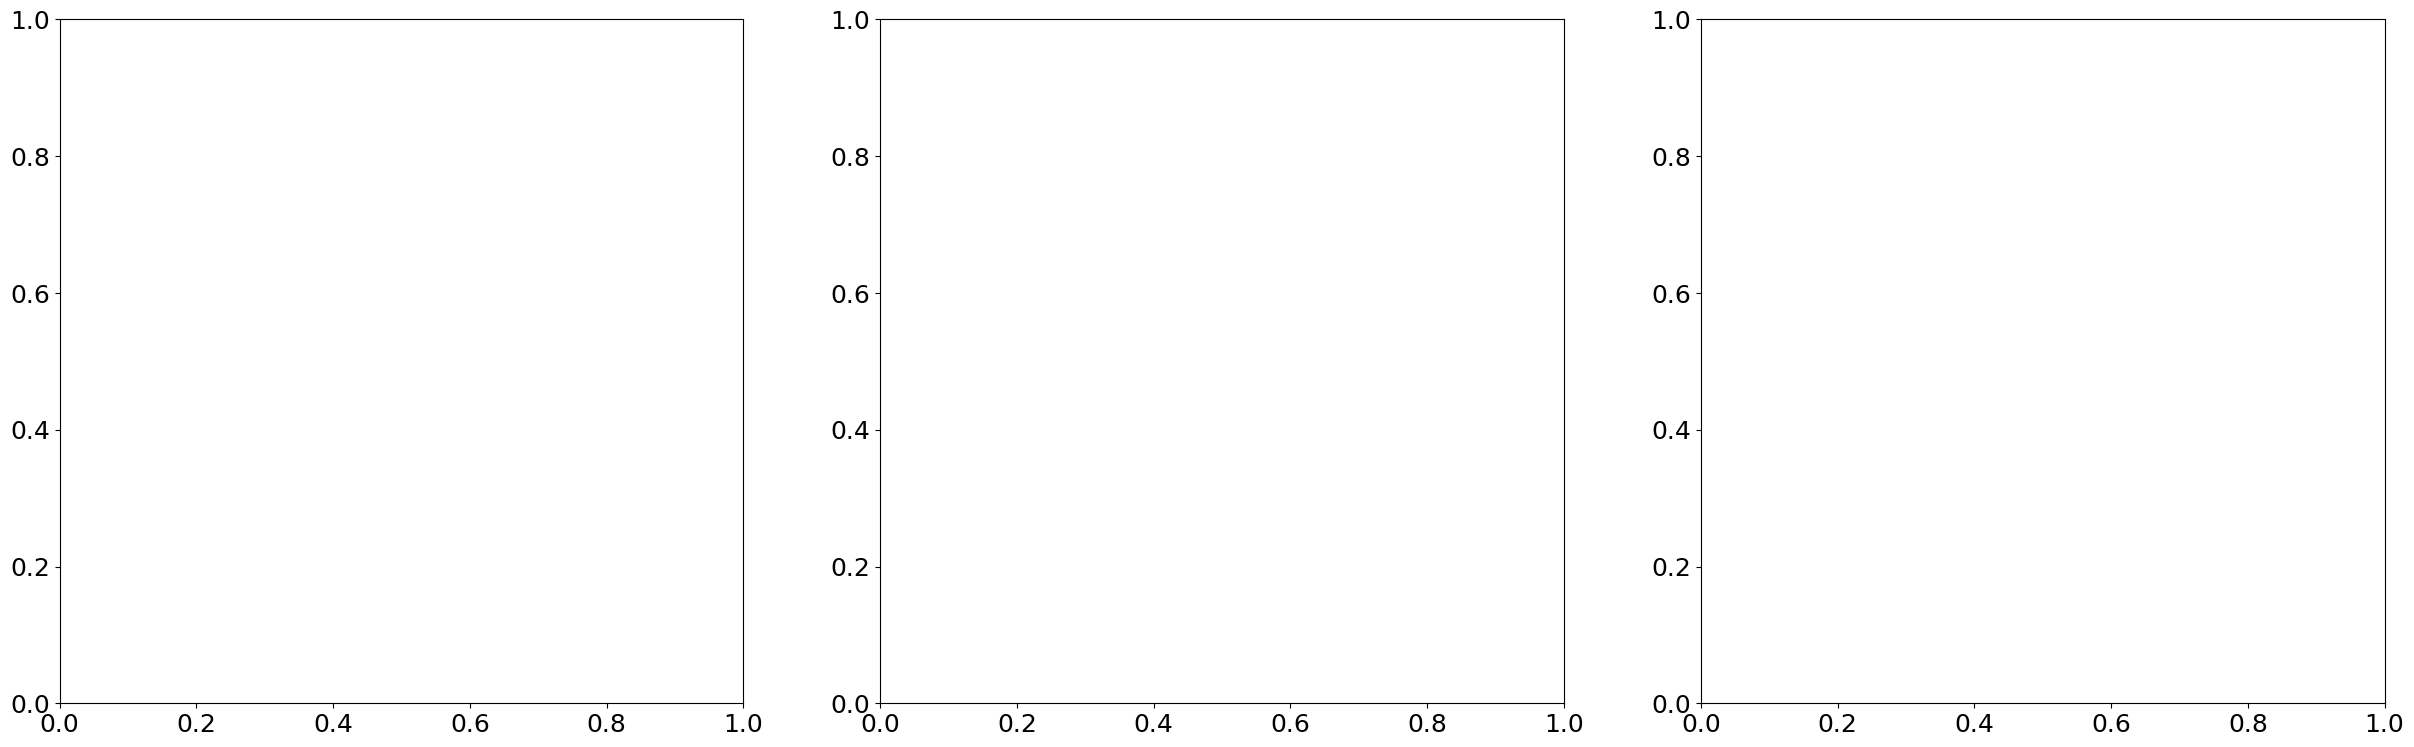

835/835 [==============================] - 1s 732us/step
Root Mean Squared Error: 6.269559664035551
(26715,)
(26715,)
RMSE for CAMROSE with neural network = 4.116
RMSE for CAMROSE with GPR = 7.6517
RMSE for CAMROSE with T-S = 4.7538


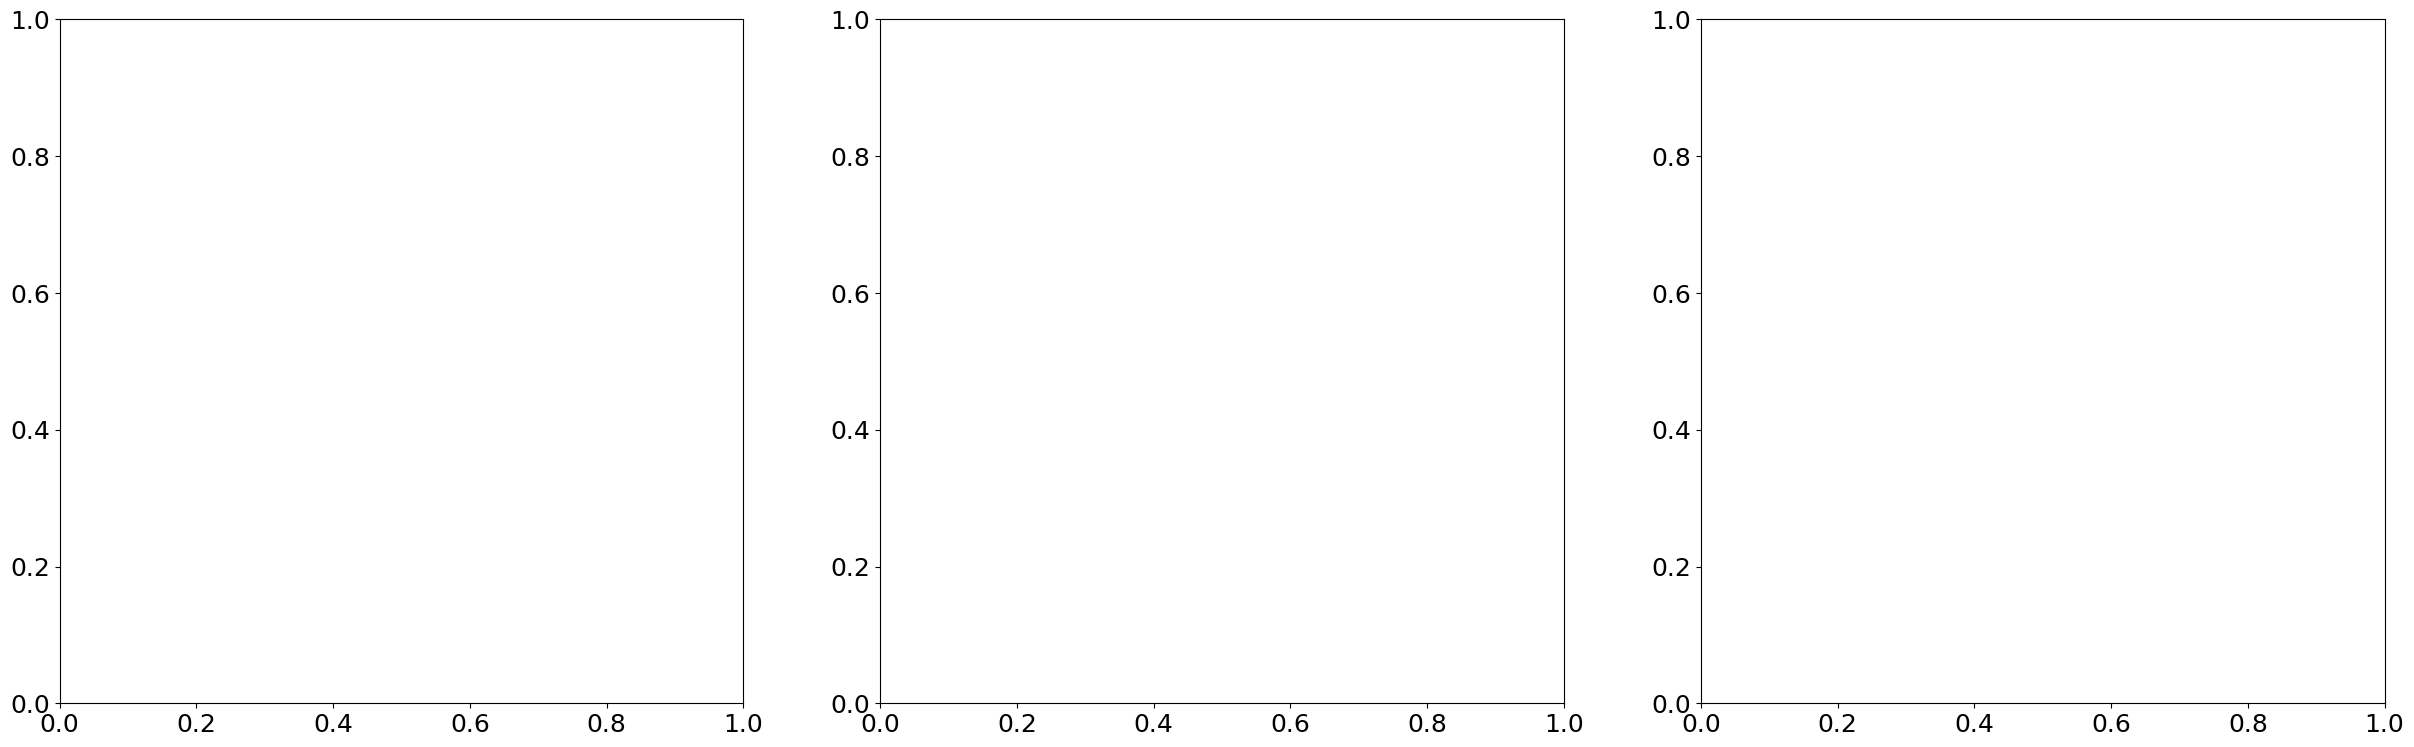

835/835 [==============================] - 1s 779us/step
Root Mean Squared Error: 6.596600667886599
(26715,)
(26715,)
RMSE for BROOKS with neural network = 5.1779
RMSE for BROOKS with GPR = 8.2128
RMSE for BROOKS with T-S = 6.5626


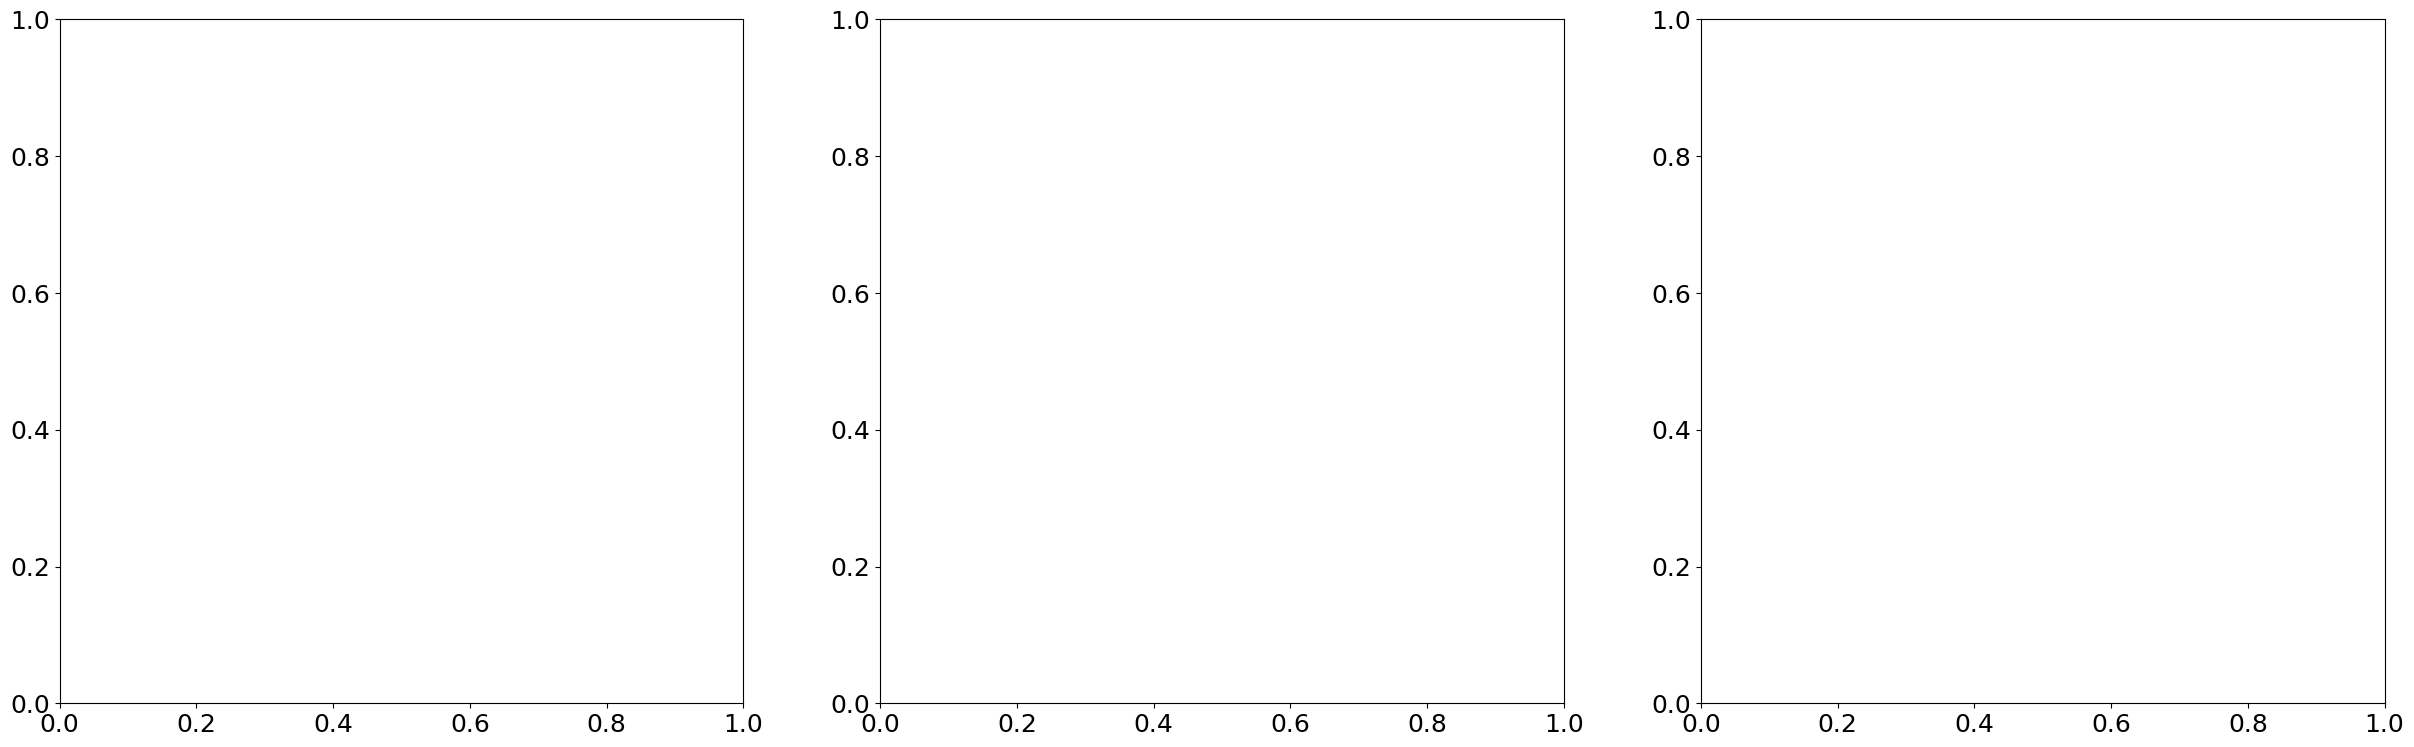

835/835 [==============================] - 0s 580us/step
Root Mean Squared Error: 7.995892729697981
(26715,)
(26715,)
RMSE for CLARESHOLM with neural network = 6.8713
RMSE for CLARESHOLM with GPR = 10.1629
RMSE for CLARESHOLM with T-S = 7.6094


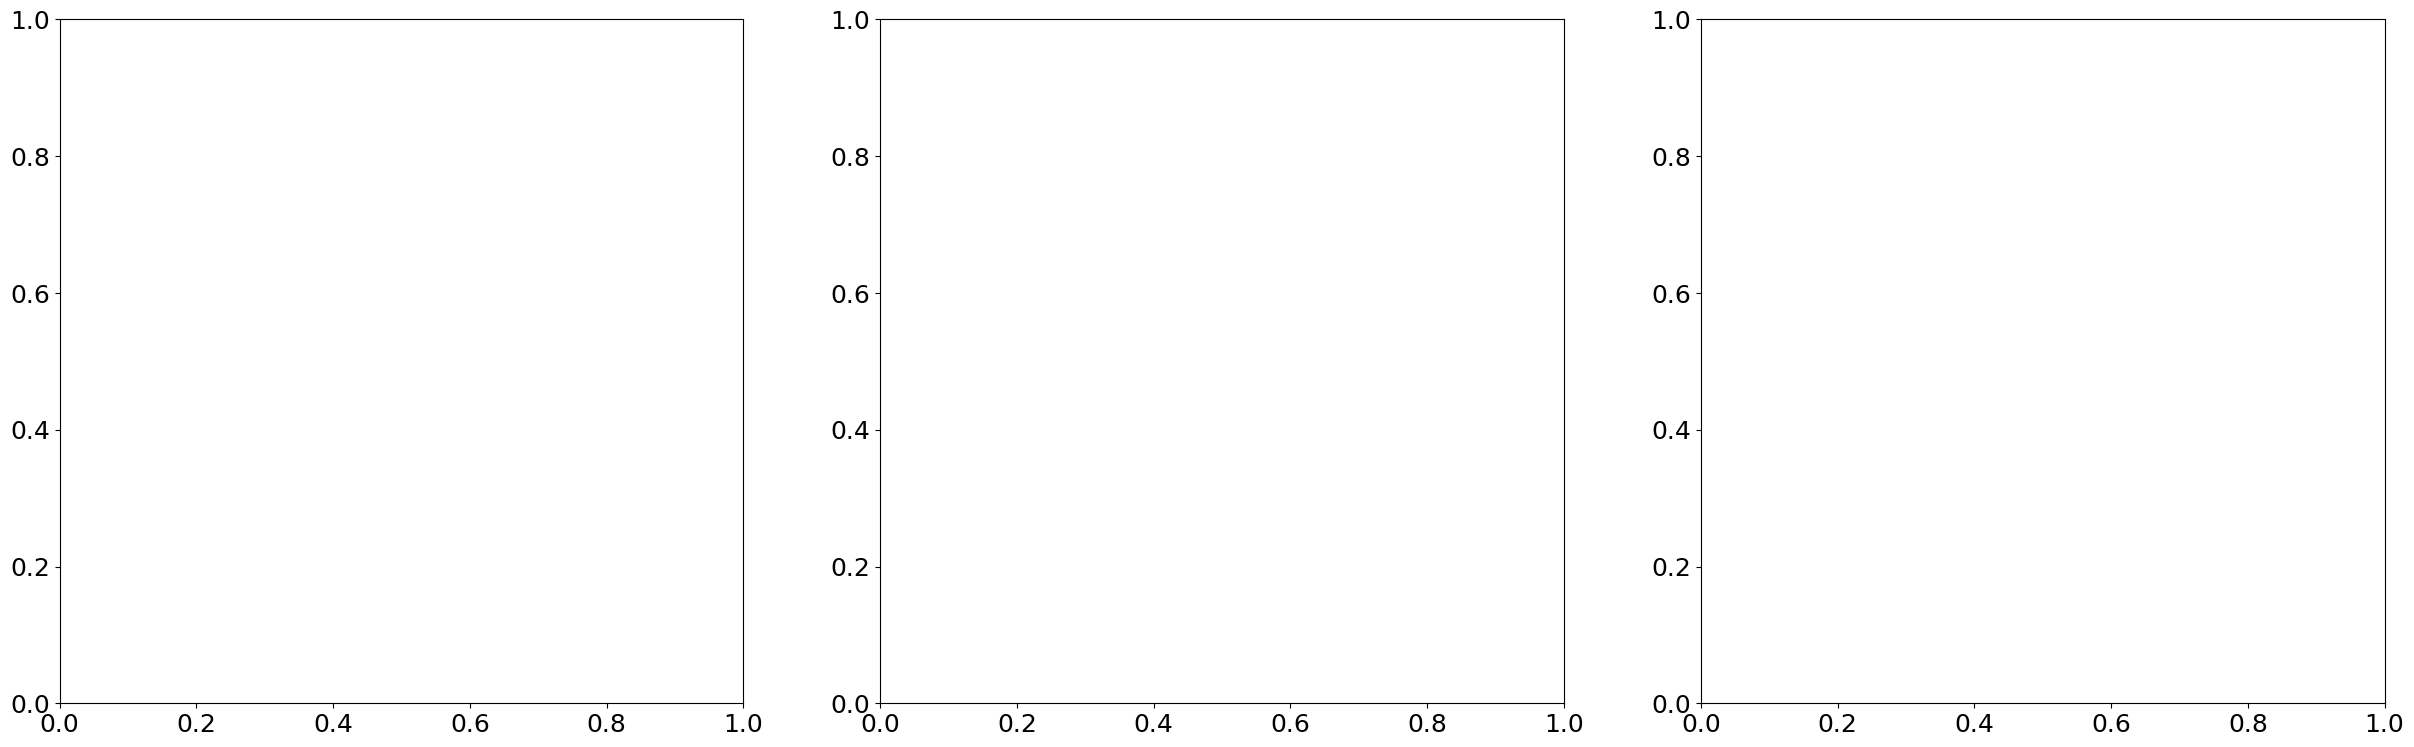

835/835 [==============================] - 1s 662us/step
Root Mean Squared Error: 8.955785083037723
(26715,)
(26715,)
RMSE for ONEFOUR CDA with neural network = 8.1891
RMSE for ONEFOUR CDA with GPR = 12.0724
RMSE for ONEFOUR CDA with T-S = 9.9612


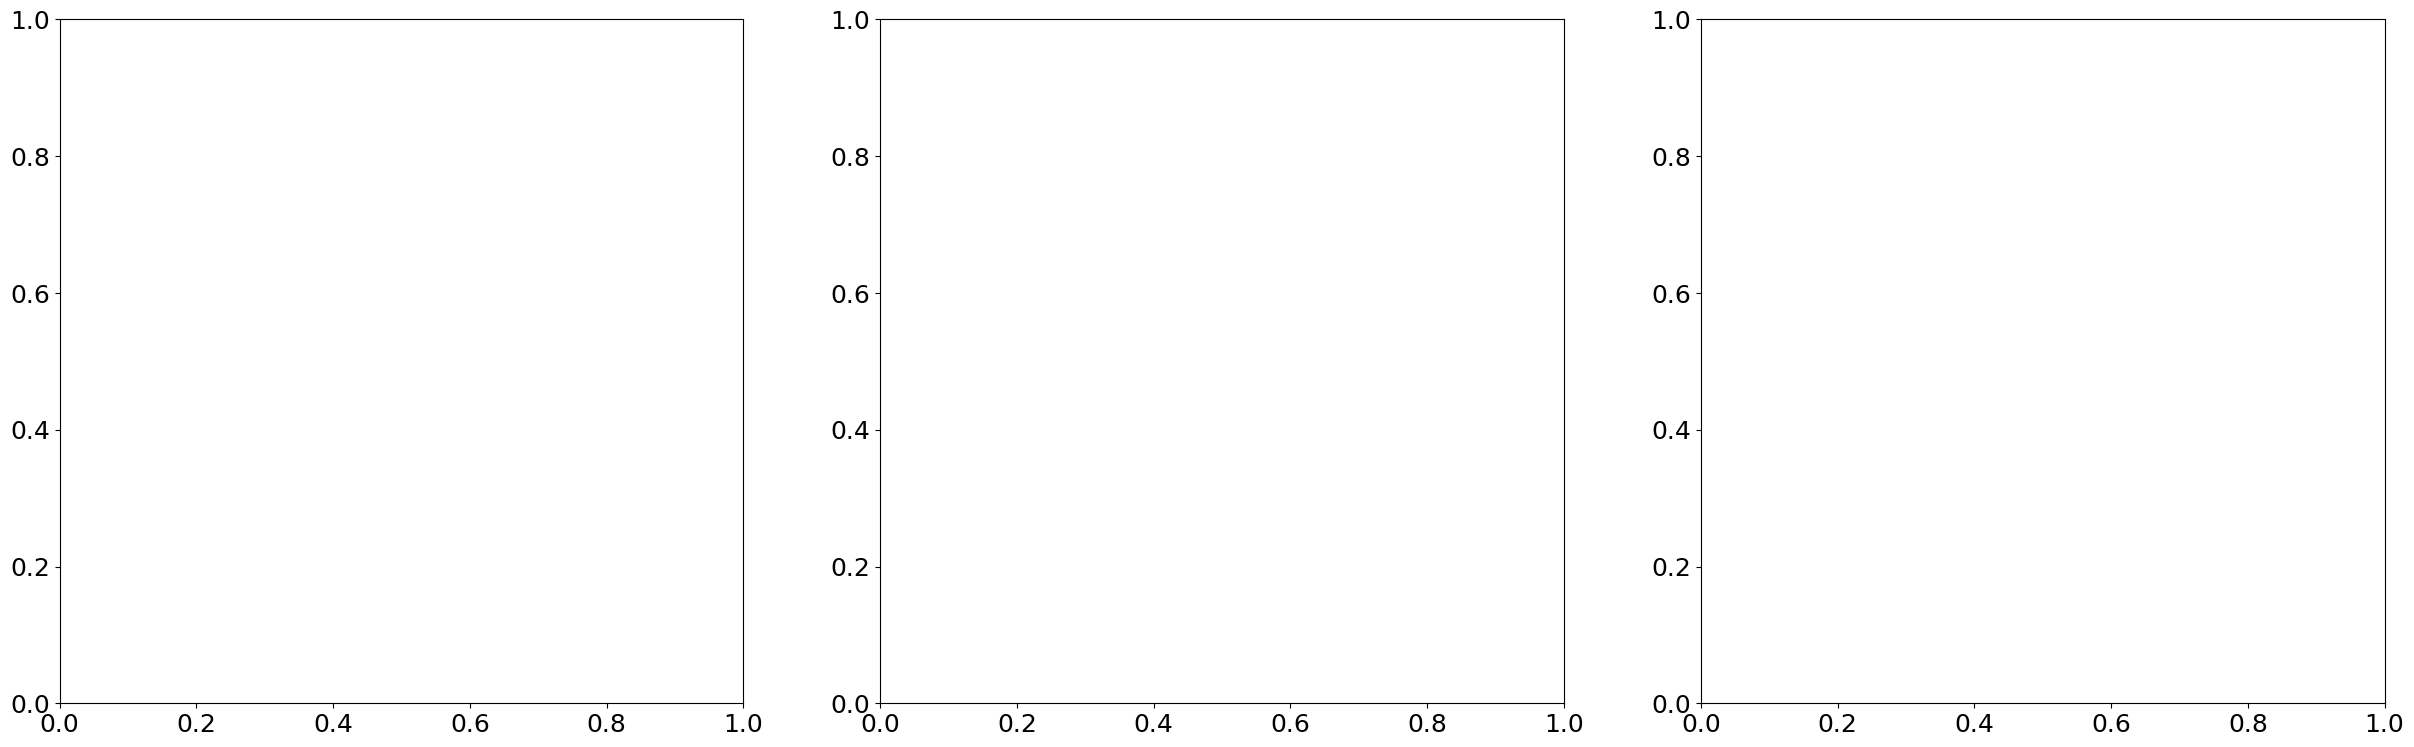

835/835 [==============================] - 0s 559us/step
Root Mean Squared Error: 6.374430301701307
(26715,)
(26715,)
RMSE for VEGREVILLE with neural network = 4.5456
RMSE for VEGREVILLE with GPR = 8.0975
RMSE for VEGREVILLE with T-S = 4.949


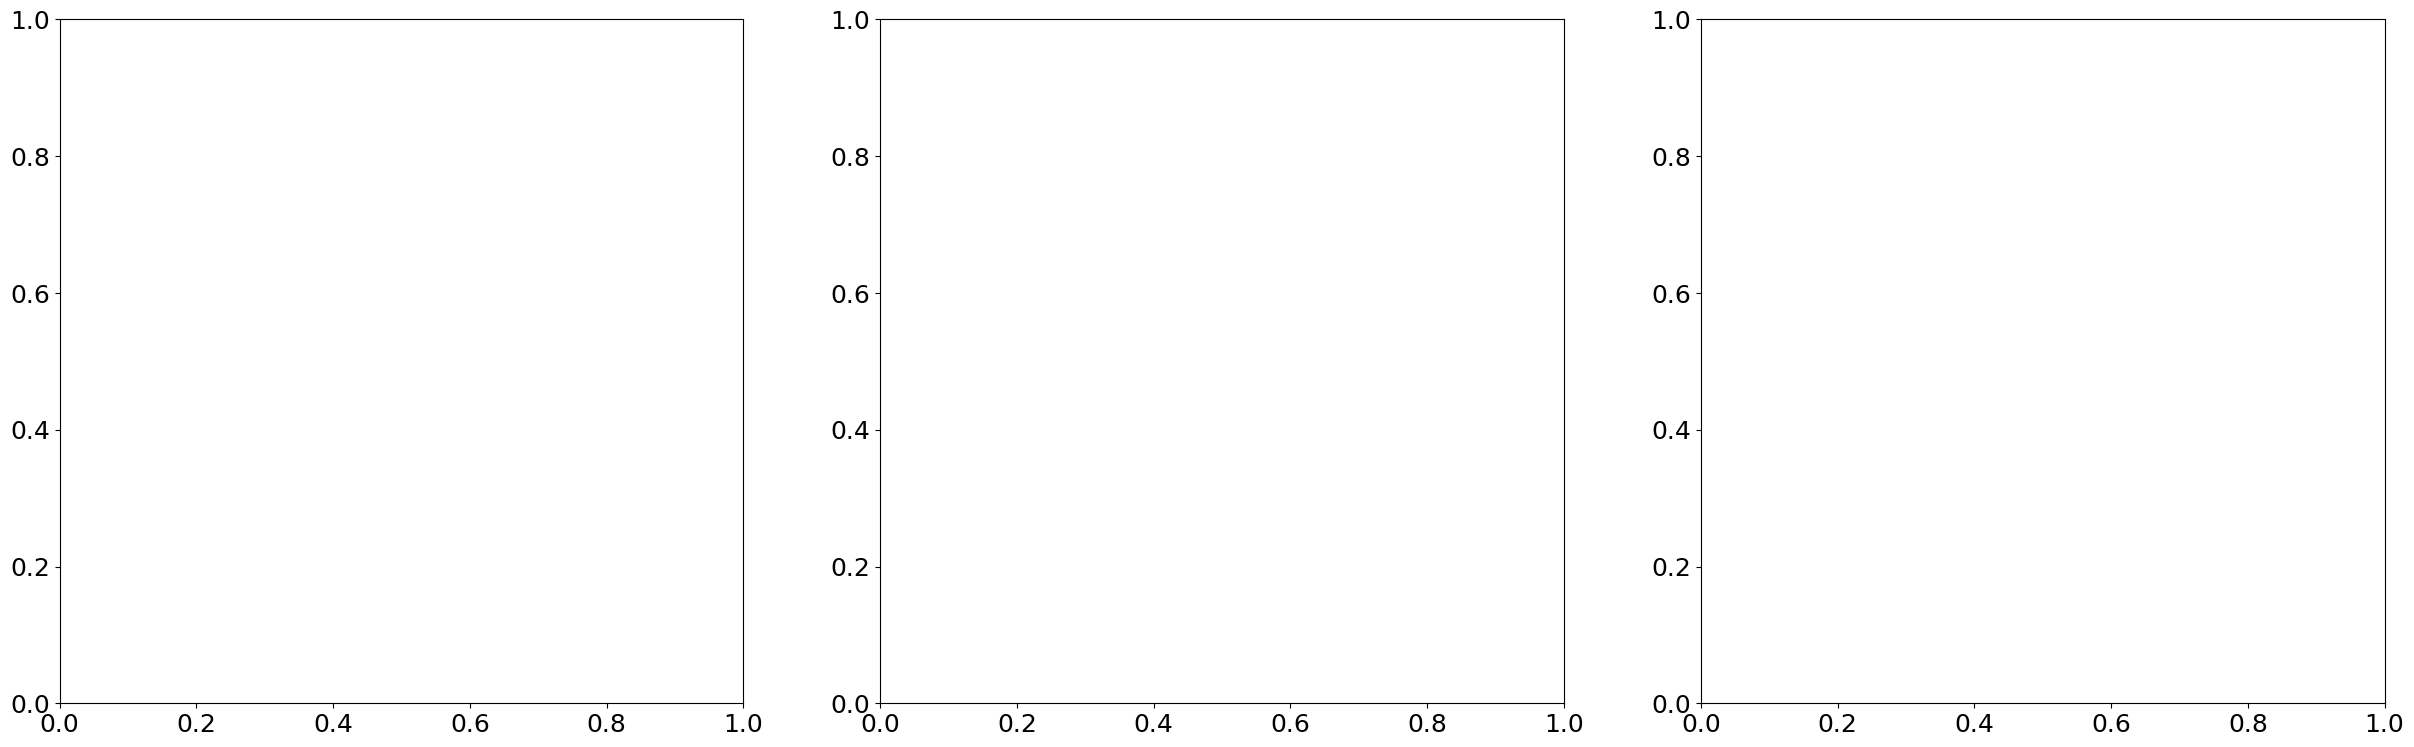

835/835 [==============================] - 0s 580us/step
Root Mean Squared Error: 7.609900622551319
(26715,)
(26715,)
RMSE for ROCKY MTN HOUSE (AUT) with neural network = 4.72
RMSE for ROCKY MTN HOUSE (AUT) with GPR = 8.6297
RMSE for ROCKY MTN HOUSE (AUT) with T-S = 5.3497


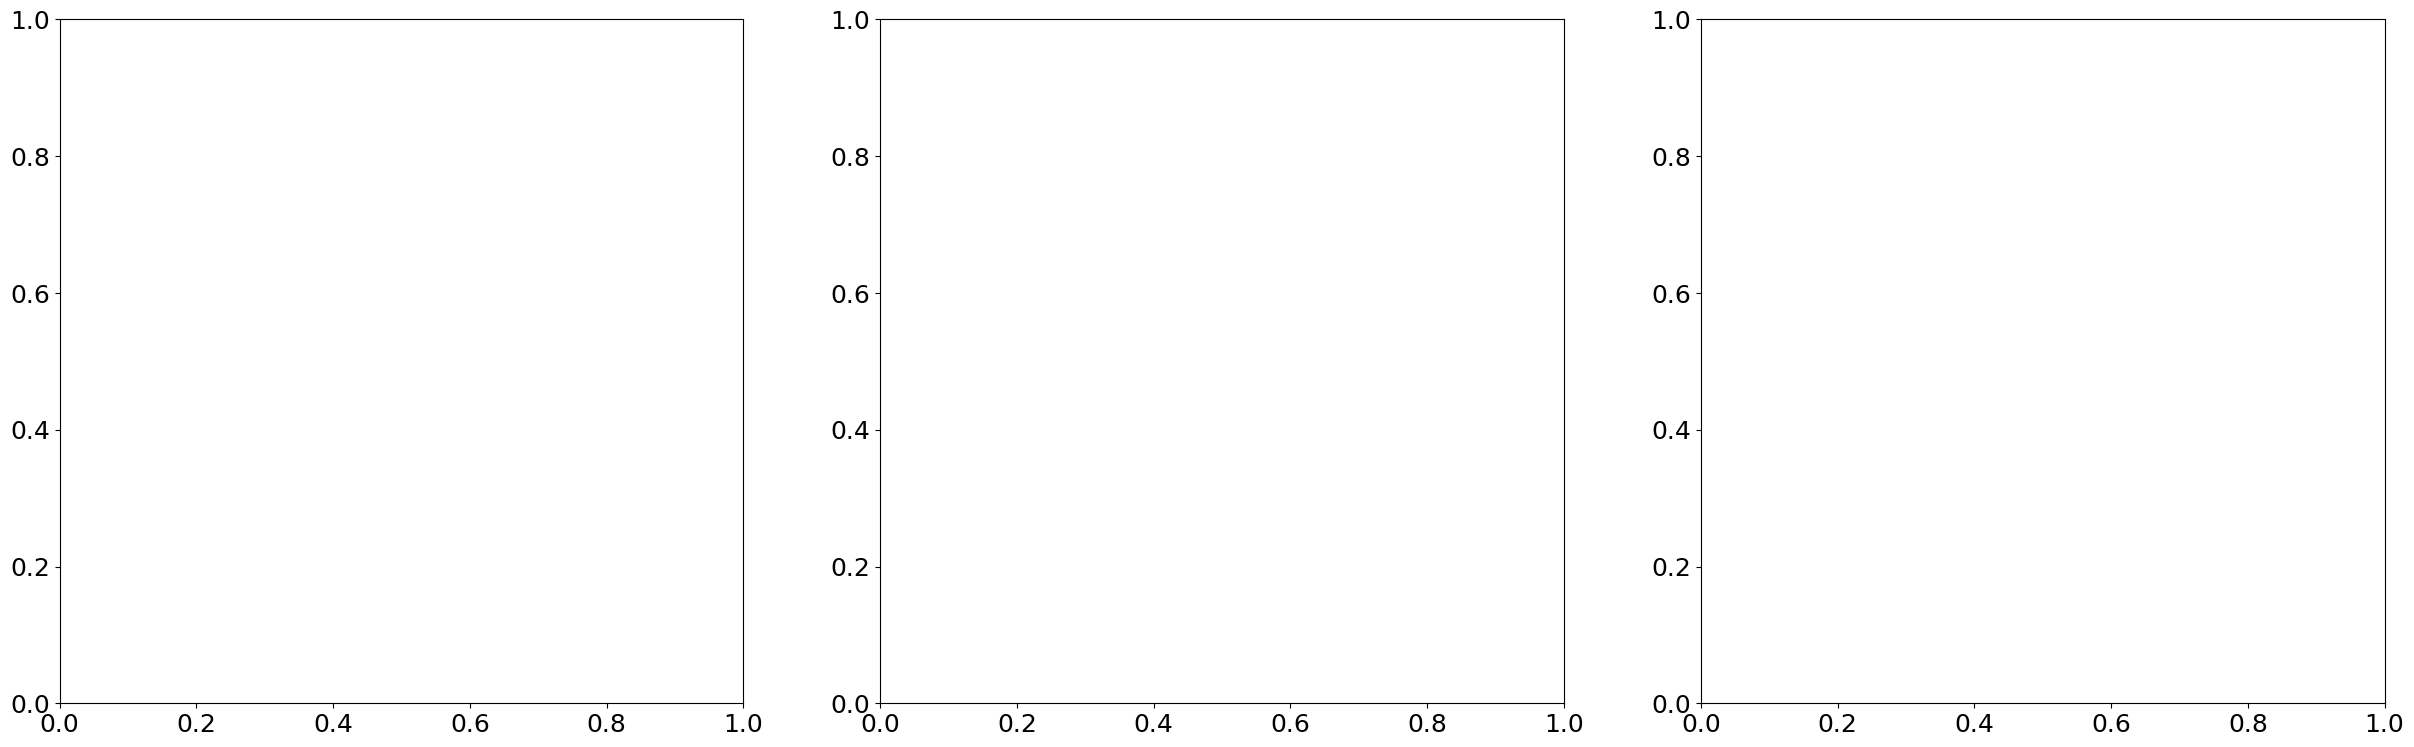

835/835 [==============================] - 1s 681us/step
Root Mean Squared Error: 7.095310308986925
(26715,)
(26715,)
RMSE for LACOMBE CDA 2 with neural network = 4.336
RMSE for LACOMBE CDA 2 with GPR = 8.3172
RMSE for LACOMBE CDA 2 with T-S = 4.6659


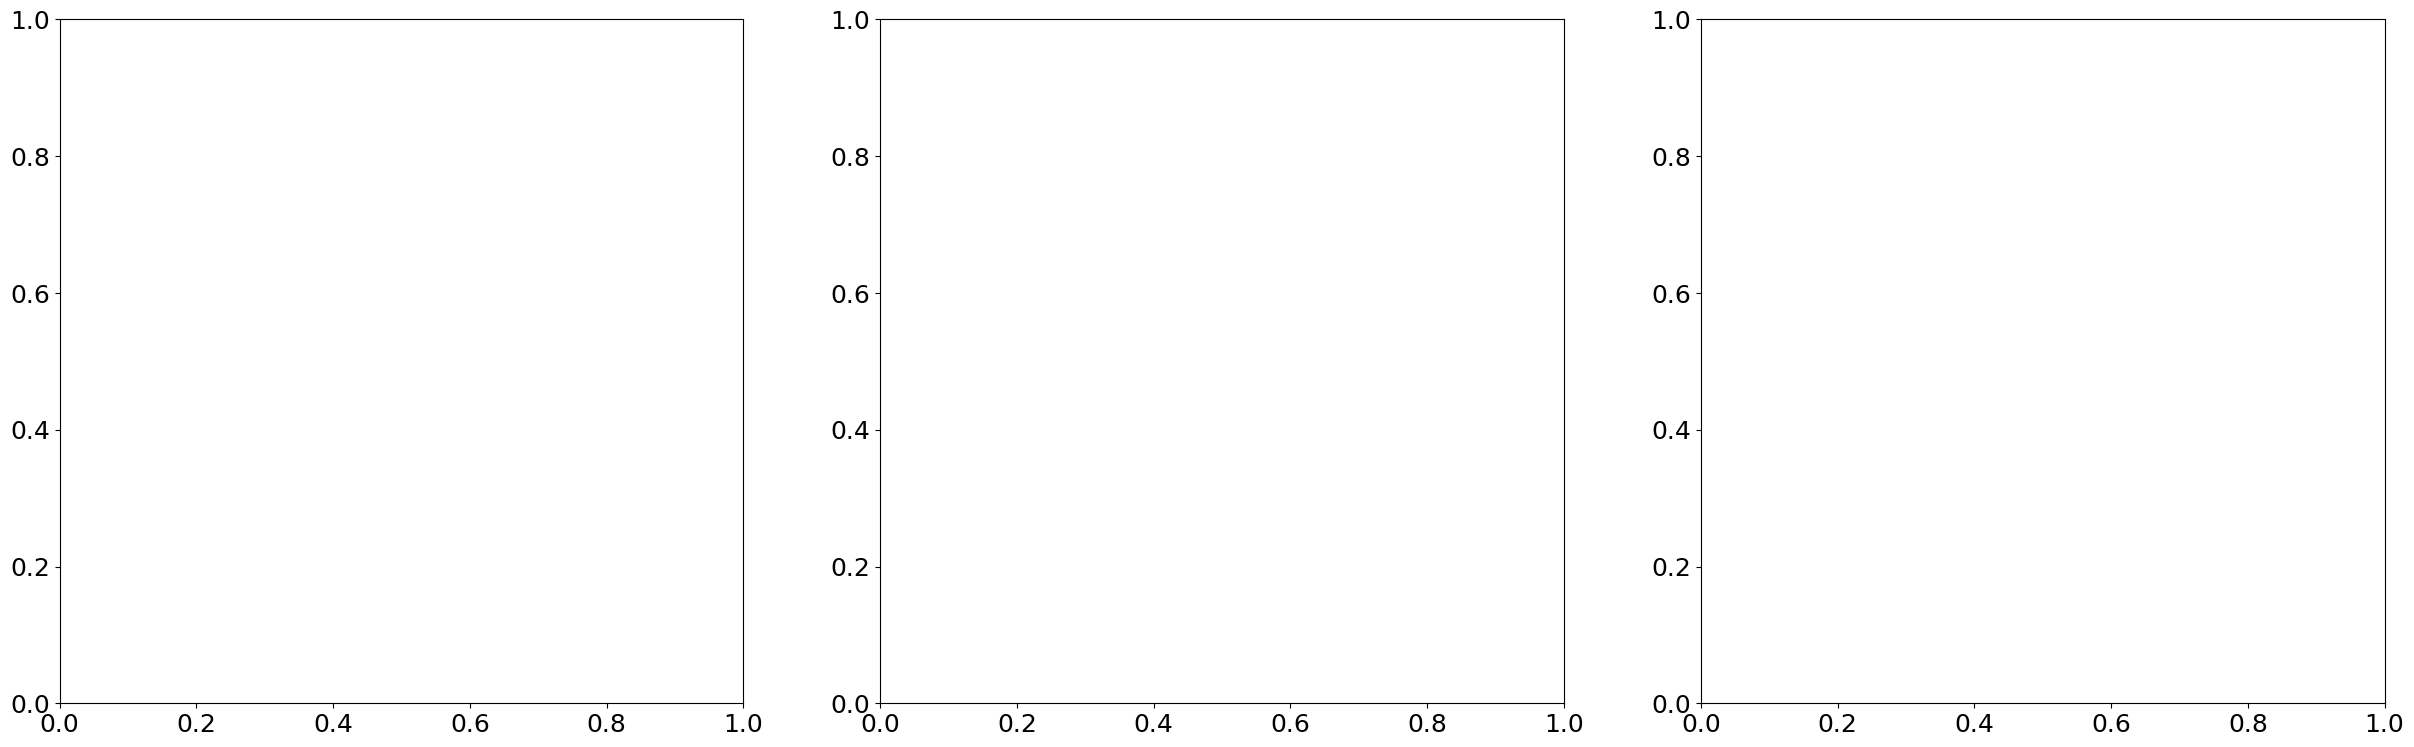

835/835 [==============================] - 1s 790us/step
Root Mean Squared Error: 6.593365536914511
(26715,)
(26715,)
RMSE for BANFF CS with neural network = 3.9524
RMSE for BANFF CS with GPR = 7.5637
RMSE for BANFF CS with T-S = 6.0173


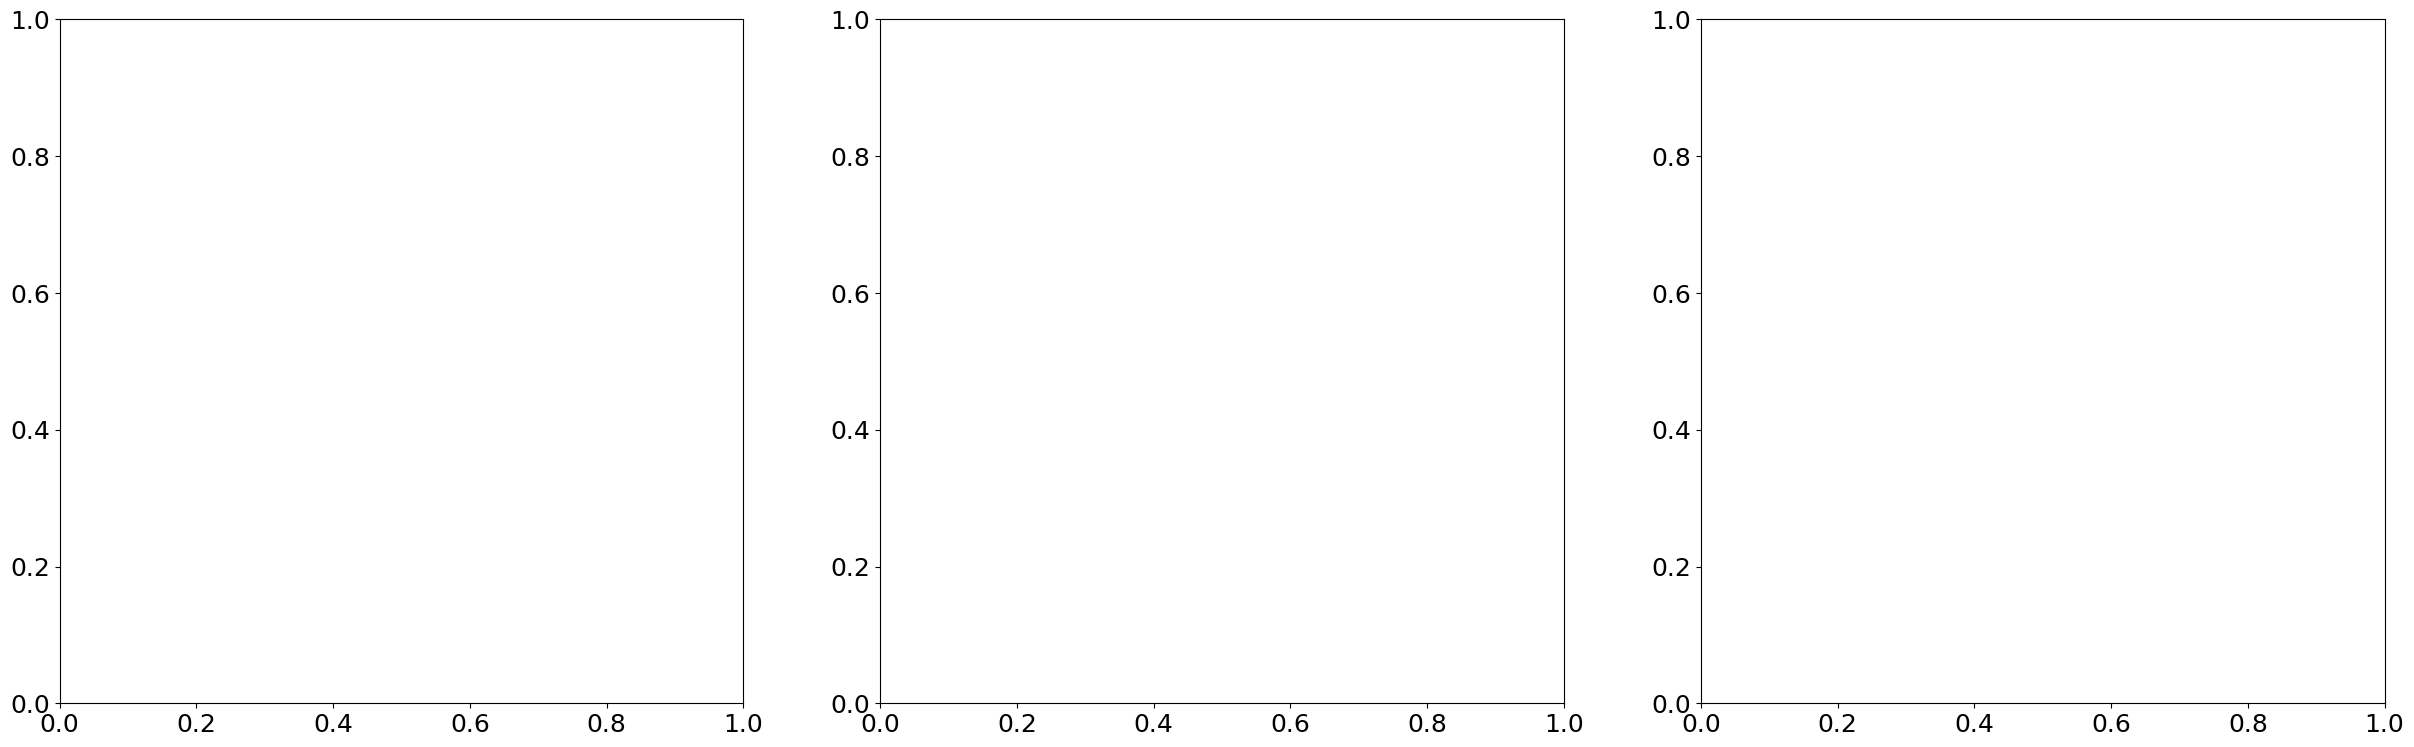

835/835 [==============================] - 1s 632us/step
Root Mean Squared Error: 7.002731248186602
(26715,)
(26715,)
RMSE for DRUMHELLER EAST with neural network = 4.7395
RMSE for DRUMHELLER EAST with GPR = 8.1858
RMSE for DRUMHELLER EAST with T-S = 5.5261


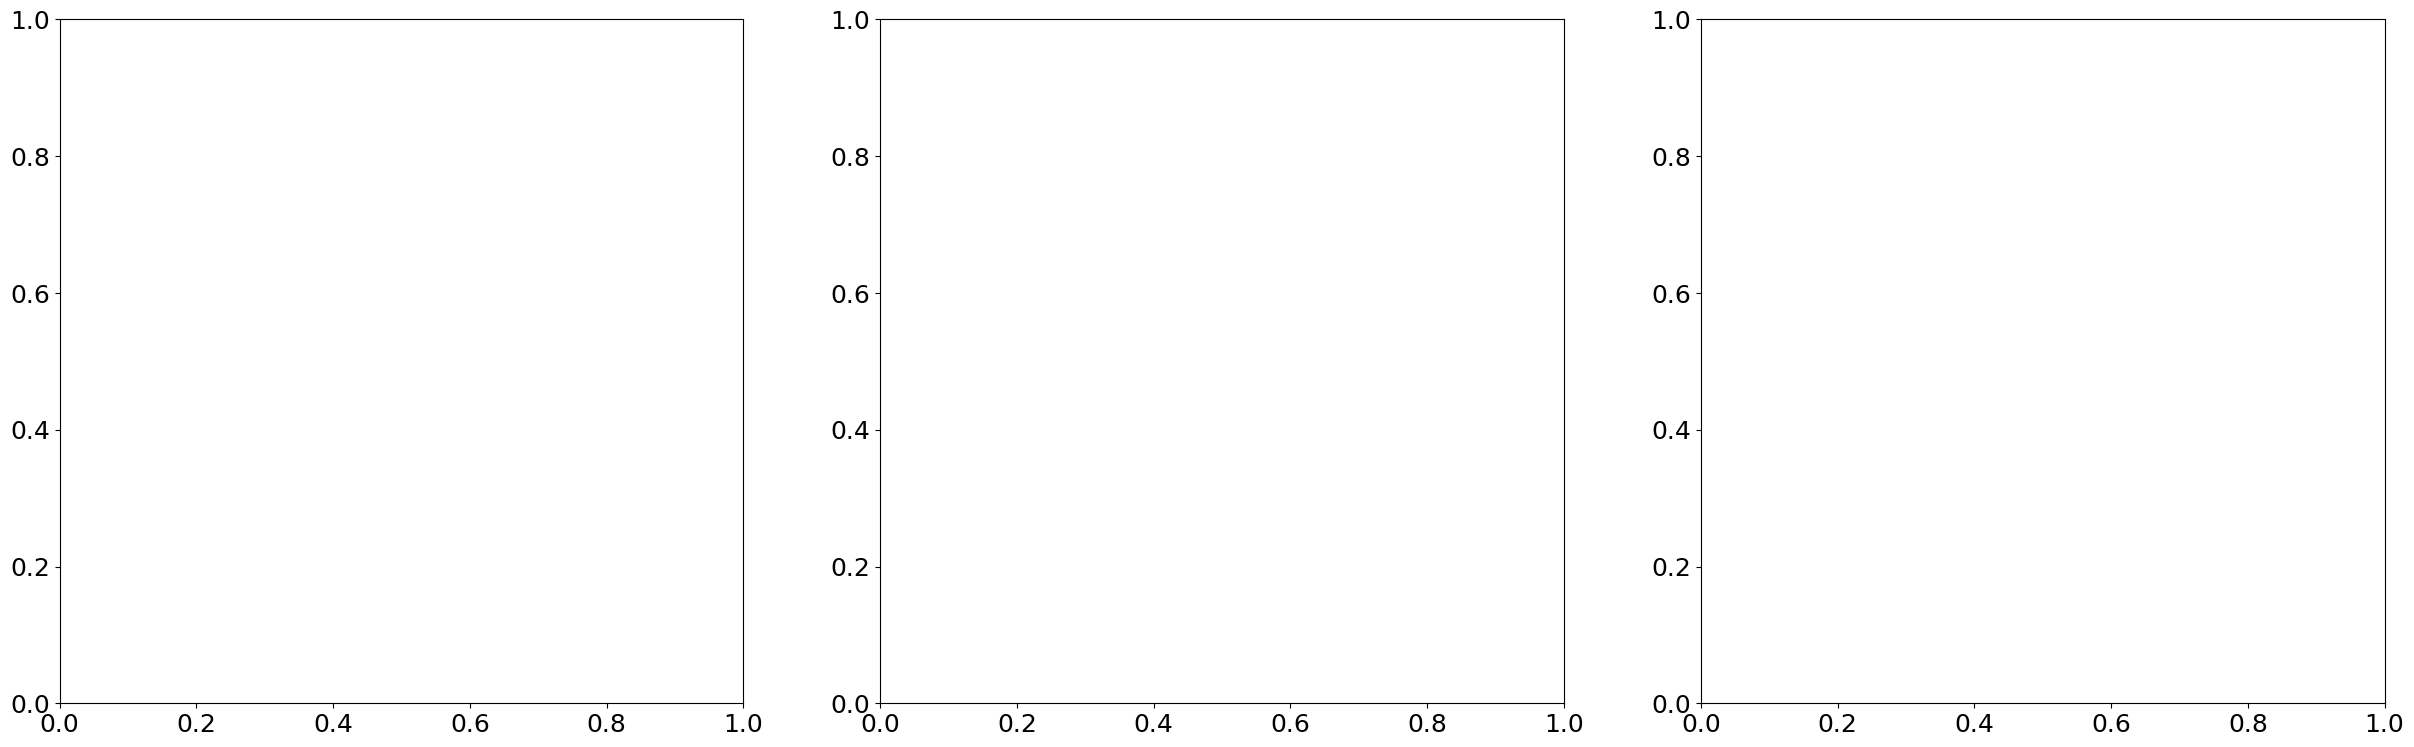

835/835 [==============================] - 1s 684us/step
Root Mean Squared Error: 7.276878941226717
(26715,)
(26715,)
RMSE for MEDICINE HAT with neural network = 4.254
RMSE for MEDICINE HAT with GPR = 9.6473
RMSE for MEDICINE HAT with T-S = 6.1667


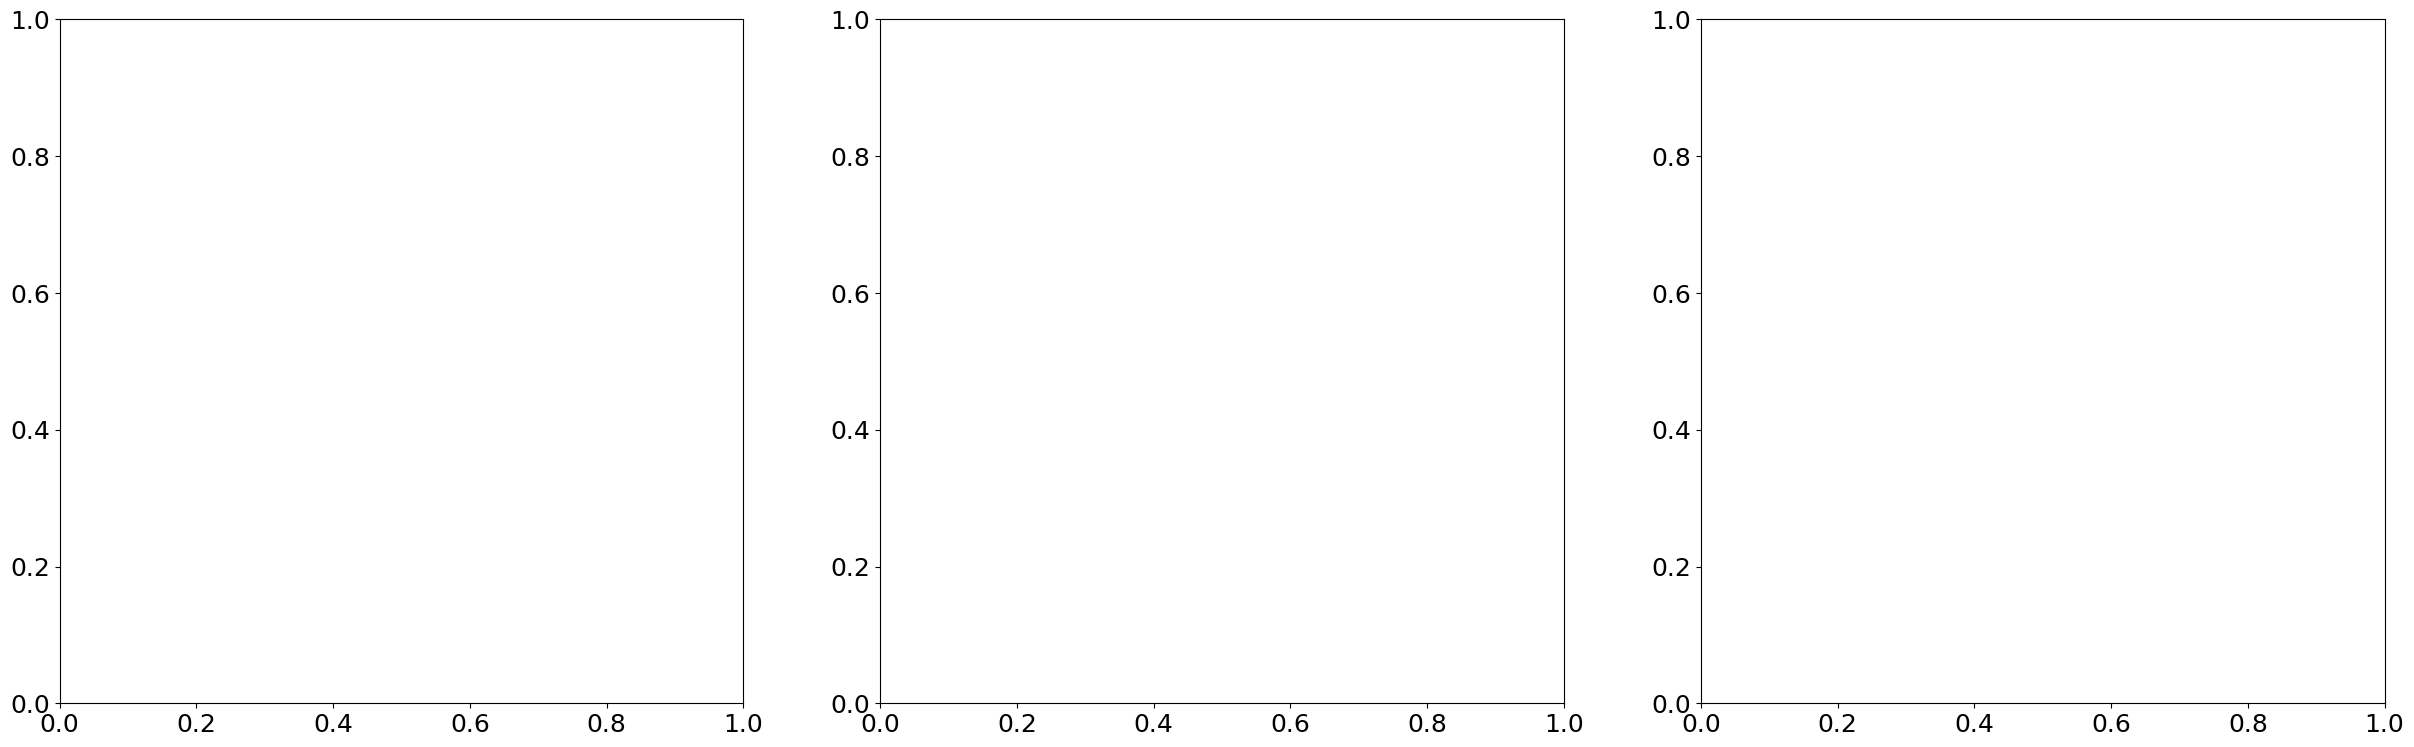

835/835 [==============================] - 1s 743us/step
Root Mean Squared Error: 10.05296925778281
(26715,)
(26715,)
RMSE for LETHBRIDGE with neural network = 6.1411
RMSE for LETHBRIDGE with GPR = 14.2339
RMSE for LETHBRIDGE with T-S = 8.7975


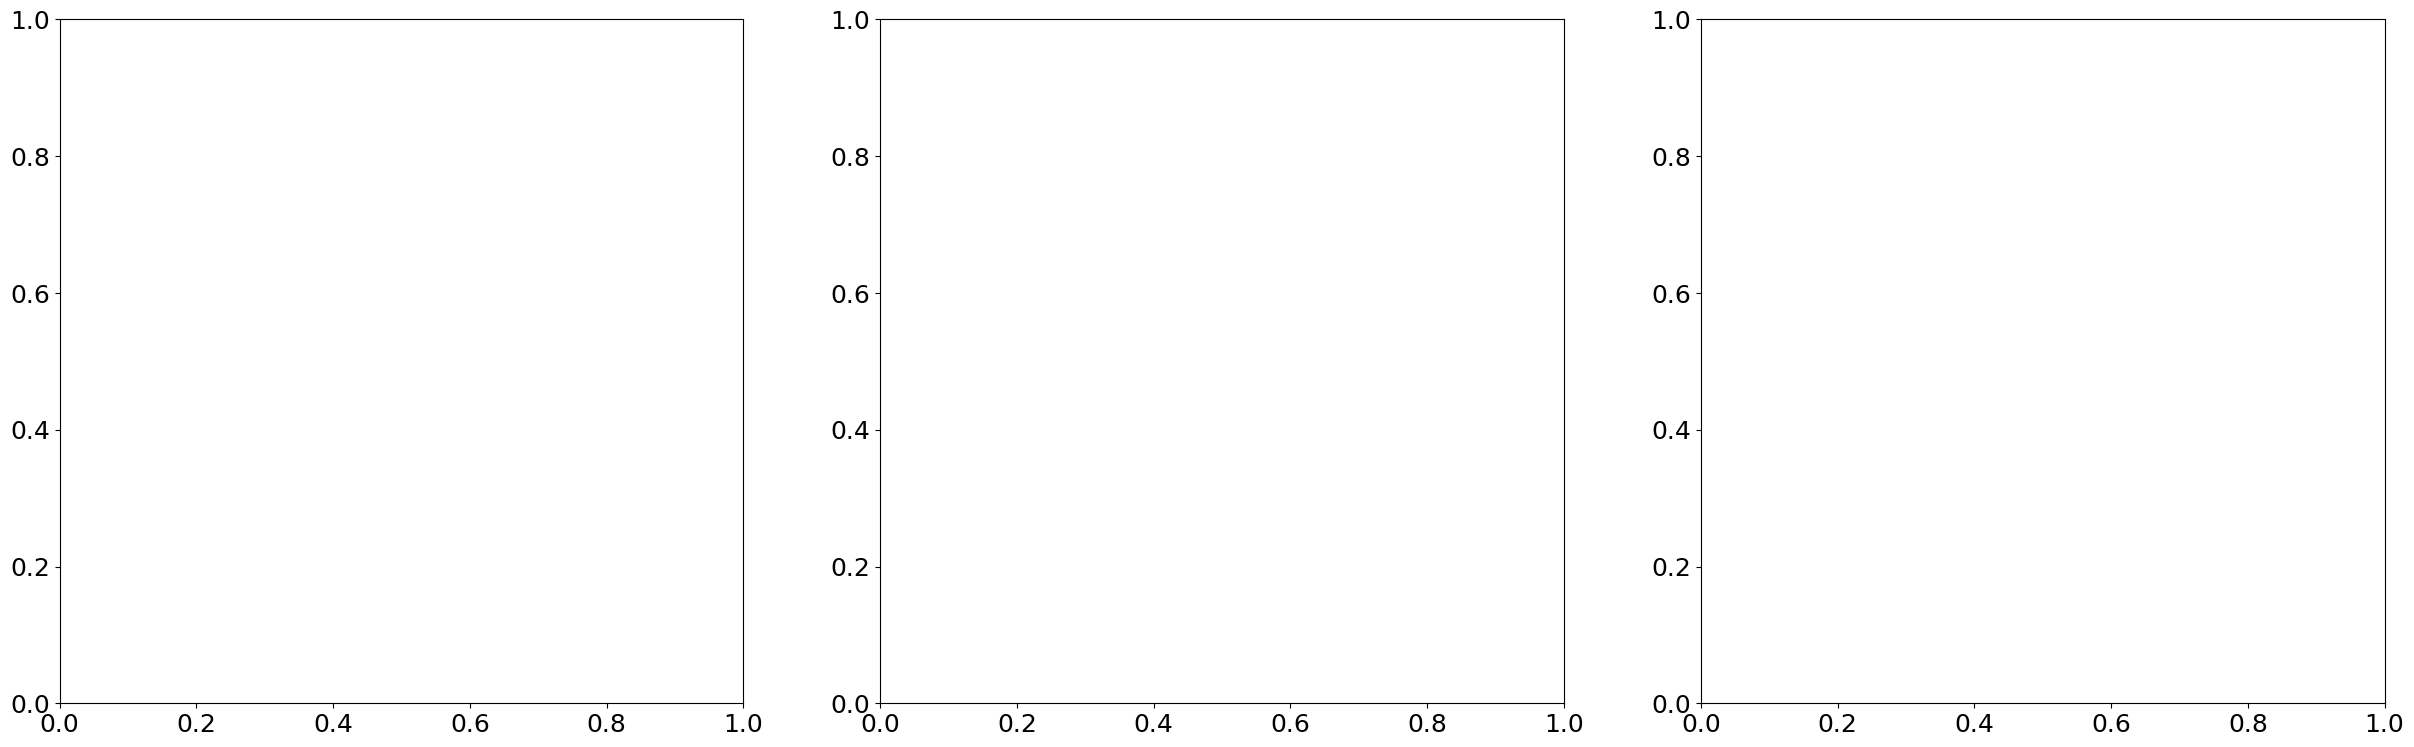

835/835 [==============================] - 1s 577us/step
Root Mean Squared Error: 6.402652743120638
(26715,)
(26715,)
RMSE for EDMONTON INTL A with neural network = 4.5446
RMSE for EDMONTON INTL A with GPR = 8.1464
RMSE for EDMONTON INTL A with T-S = 5.5046


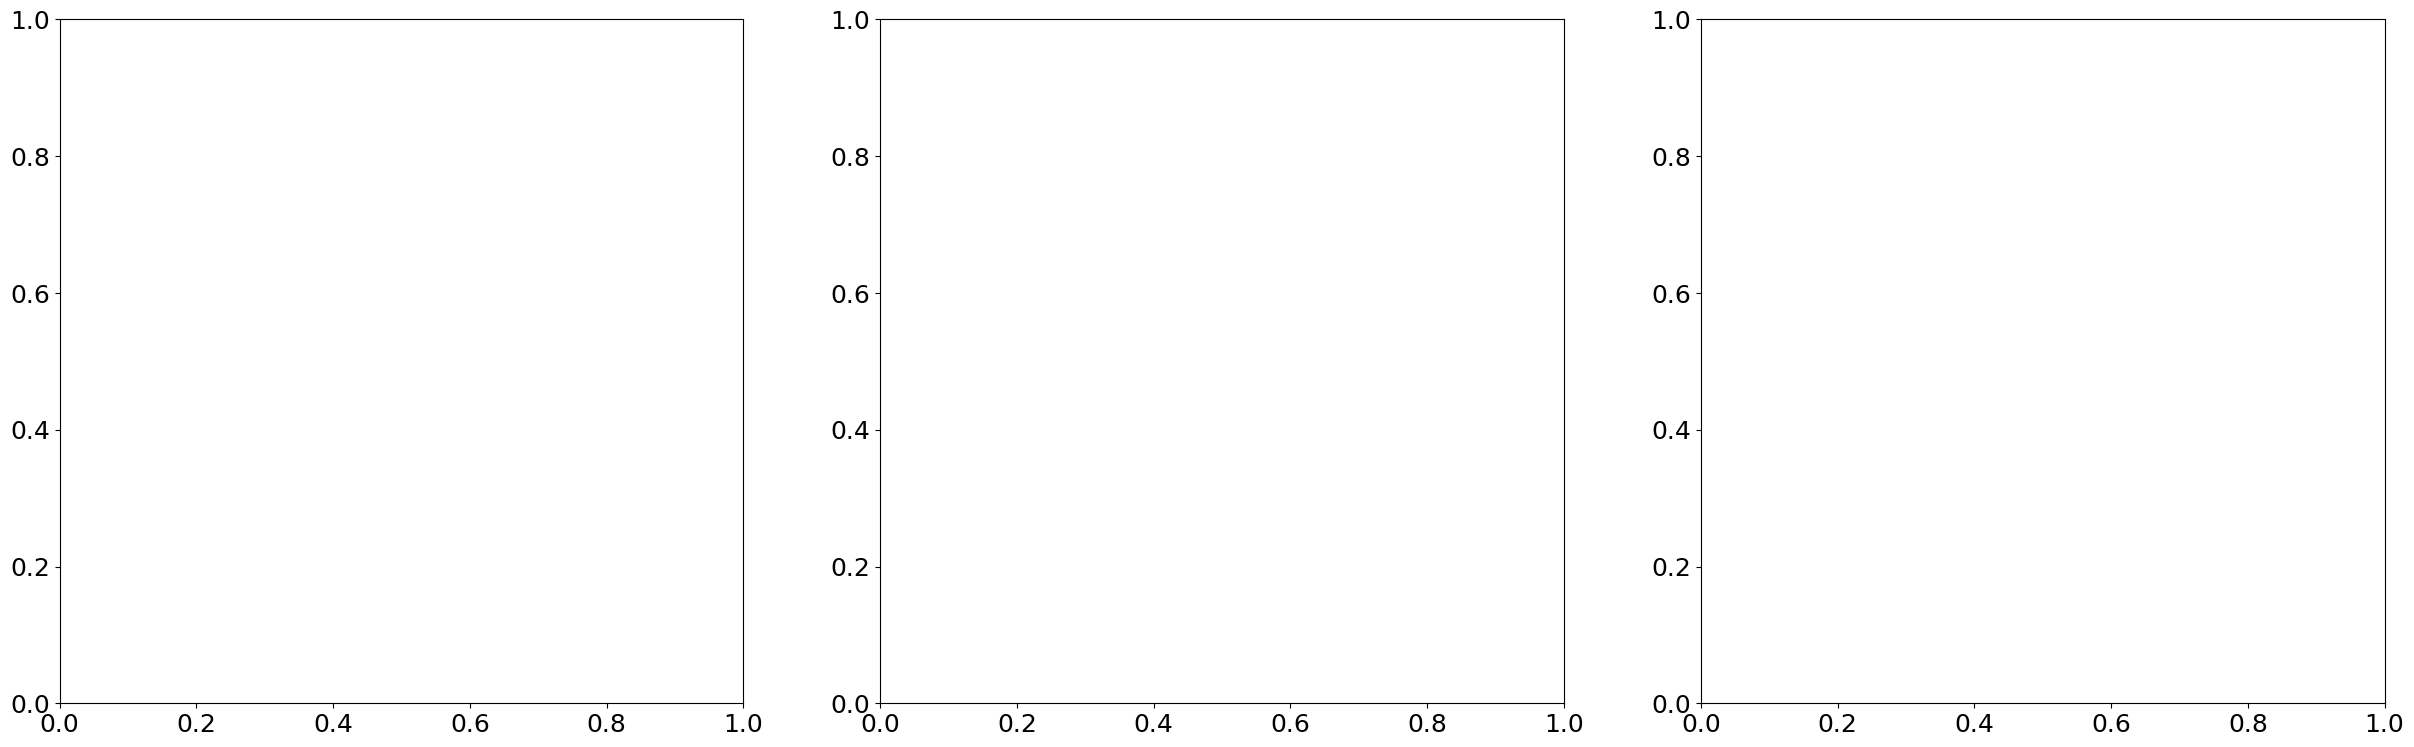

835/835 [==============================] - 1s 649us/step
Root Mean Squared Error: 7.121080365384415
(26715,)
(26715,)
RMSE for CALGARY INTL A with neural network = 6.4531
RMSE for CALGARY INTL A with GPR = 9.0952
RMSE for CALGARY INTL A with T-S = 7.1673


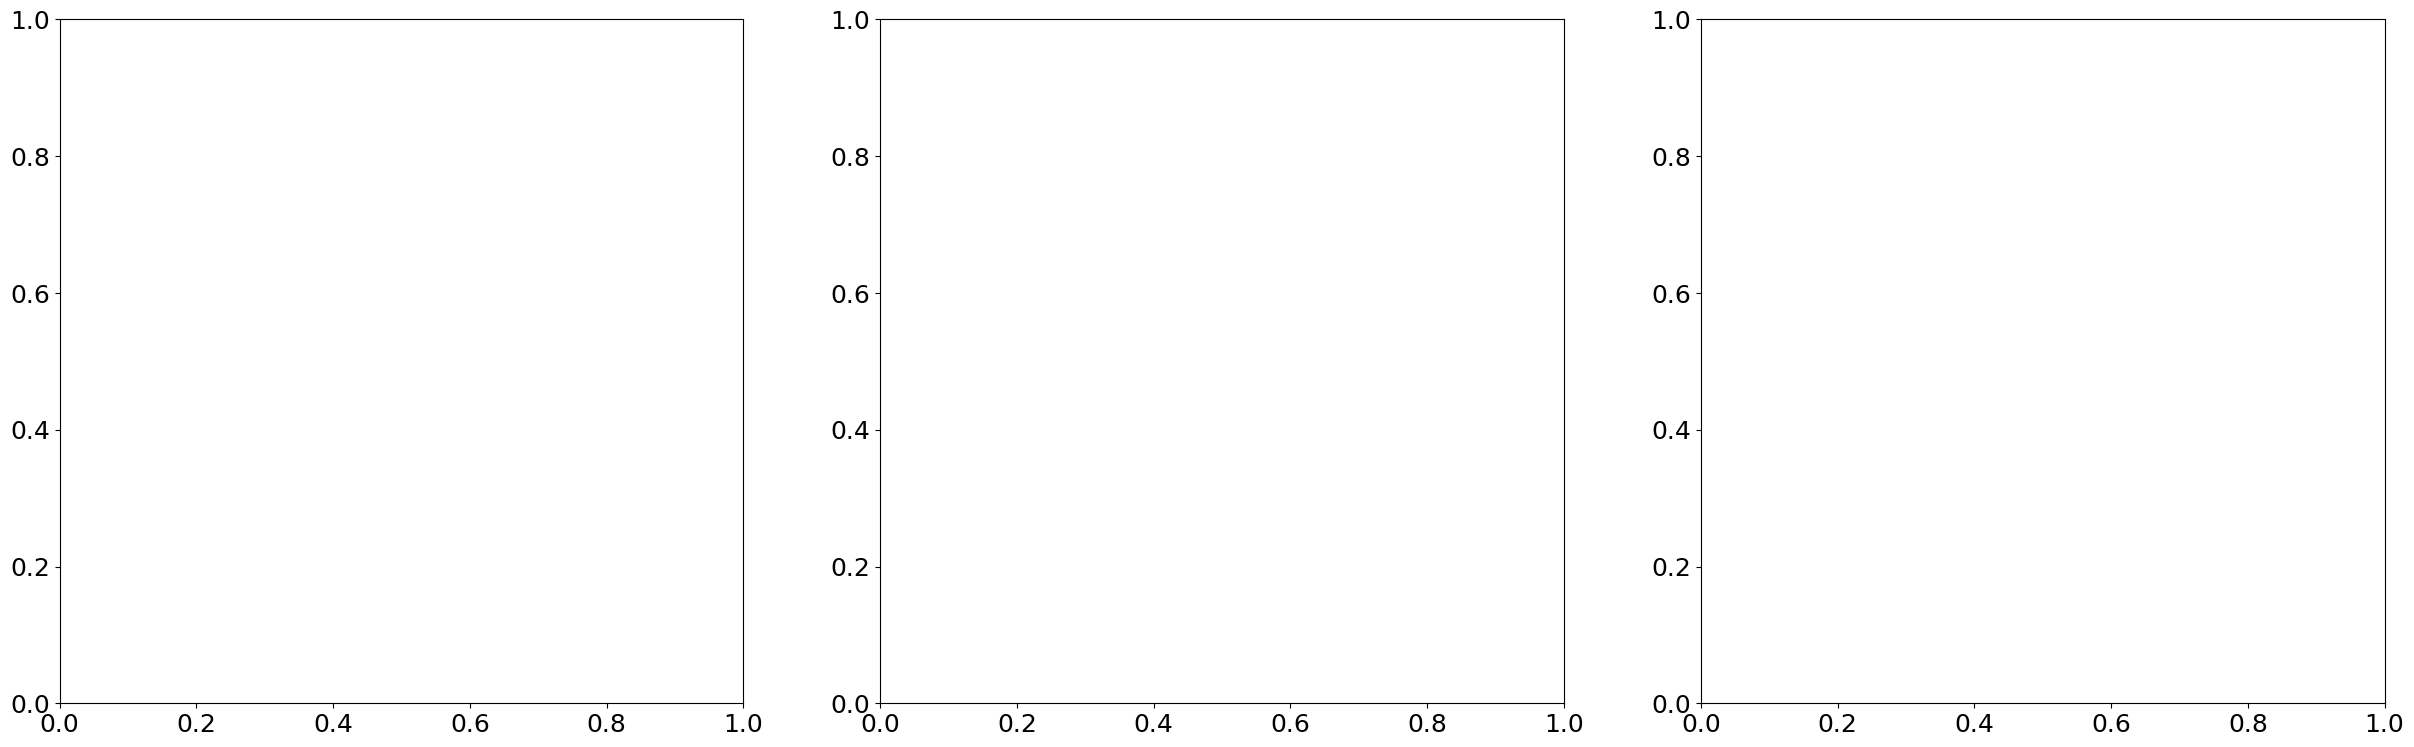

In [91]:
# plots for testing data
test_x = []
test_y = []

for station in stations_to_test:
    # x is already normalized
    x = pd.read_csv(f'Data/visualization_data/{station}_x.csv', index_col=0).to_numpy()
    y = pd.read_csv(f'Data/visualization_data/{station}_y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)
    
    nn_prediction = np.array(neural_network_model.predict(x)).flatten()

    gpr_prediction_means,_ = gpr_mdoel.predict(scaler.inverse_transform(x), y)
    gpr_prediction = []
    for gpr_prediction_means_i in gpr_prediction_means:
        gpr_prediction = np.concatenate((gpr_prediction, gpr_prediction_means_i))
    #gpr_prediction = gpr_prediction.reshape(-1,1)
    print(gpr_prediction.shape)
    
    ts_prediction = ts_model.predict(x)
    print(ts_prediction.shape)

    plot_side_by_side_prediction_error(y, nn_prediction, gpr_prediction, ts_prediction, station)


In [ ]:
# generate a grid of points for visualization
def generate_grid_points():
    longitude = np.linspace(-110.07, -115.55, 10)
    latitude = np.linspace(49.12, 53.55, 10)
    xx, yy = np.meshgrid(latitude, longitude)
    return np.array(list(zip(xx.flatten(), yy.flatten())))

In [ ]:
grid_coor = generate_grid_points()

In [93]:
def find_clostest_n_neighbours(target, unique_stations, number_of_neighbours):
    station_with_locations = unique_stations.copy()

    distances = station_with_locations.apply(
        lambda row: distance.distance(
            [row['latitude'], row['longitude']], [target[0], target[1]]).km,
        axis=1
    )
    station_with_locations['distance'] = distances

    station_in_range = station_with_locations.loc[(station_with_locations['distance'] >= 0)
                                                  & (station_with_locations['distance'] <= 99999)]

    station_to_use = station_in_range.nsmallest(number_of_neighbours, 'distance')
    
    return station_to_use


def extract_data(features, target_coor, features_to_use=None, target_features_to_use=None):
    if features_to_use is None:
        features_to_use = ['latitude', 'longitude', 'temp', 'wind_direction', 'wind_speed']
    if target_features_to_use is None:
        target_features_to_use = ['wind_speed']

    distances = features.apply(
        lambda row: distance.distance(
            [row['latitude'], row['longitude']], [target_coor[0], target_coor[1]]).km,
        axis=1
    )

    processed_features = features.loc[:,features_to_use].copy()
    processed_features['distance'] = distances

    processed_features = processed_features.to_numpy()

    return processed_features


# Note some station will have less data, so the smallest date range is used to mach all stations
def extract_data_match_date_range(features, target_coor, neighbour_station_names):
    processed_features = []

    for name in neighbour_station_names:
        selected_station_data = features.loc[features['name'] == name]
        extracted_features = extract_data(selected_station_data, target_coor)
        if len(processed_features) == 0:
            processed_features = extracted_features
        else:
            processed_features = np.concatenate((processed_features, extracted_features), axis=1)

    return processed_features    

# Given the target station name, find the nearest neighbours within the distance
def generate_data(raw_data, target_coor, number_of_neighbours):

    target_latitude = target_coor[0]
    target_longitude = target_coor[1]

    # select all unique names and coordinates
    unique_stations = raw_data.groupby('name').head(1)

    neighbour_stations = find_clostest_n_neighbours([target_latitude, target_longitude], unique_stations, number_of_neighbours)

    # find k nearest neighbours
    neighbour_station_names = neighbour_stations['name']

    # filter the data, return
    features = raw_data[raw_data['name'].isin(neighbour_station_names)]
    features = extract_data_match_date_range(features, target_coor, neighbour_station_names)

    return features


In [94]:
grid_df = pd.read_csv('Data/processed_ab_no_precp_train.txt')
latest_one_month_records = grid_df.sort_values('date', ascending=False).head(20*300)


C:\Users\PPL\AppData\Local\Temp\ipykernel_18212\2452982092.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  grid_df = pd.read_csv('Data/processed_ab_no_precp_train.txt')


In [96]:
latest_one_month_records['date'].unique()

array(['2023-09-14 20:00', '2023-09-14 19:00', '2023-09-14 18:00',
       '2023-09-14 07:00', '2023-09-14 06:00', '2023-09-14 05:00',
       '2023-09-14 04:00', '2023-09-14 03:00', '2023-09-14 01:00',
       '2023-09-13 20:00', '2023-09-13 17:00', '2023-09-13 16:00',
       '2023-09-13 15:00', '2023-09-13 13:00', '2023-09-13 12:00',
       '2023-09-13 10:00', '2023-09-13 09:00', '2023-09-13 08:00',
       '2023-09-13 07:00', '2023-09-13 05:00', '2023-09-13 03:00',
       '2023-09-13 02:00', '2023-09-12 18:00', '2023-09-12 17:00',
       '2023-09-12 16:00', '2023-09-12 15:00', '2023-09-11 22:00',
       '2023-09-11 20:00', '2023-09-11 19:00', '2023-09-11 18:00',
       '2023-09-11 17:00', '2023-09-11 16:00', '2023-09-11 15:00',
       '2023-09-11 14:00', '2023-09-11 12:00', '2023-09-11 11:00',
       '2023-09-11 09:00', '2023-09-11 07:00', '2023-09-11 06:00',
       '2023-09-11 04:00', '2023-09-11 03:00', '2023-09-11 02:00',
       '2023-09-11 01:00', '2023-09-10 20:00', '2023-09-10 17:

In [ ]:
nn_grid_predicitions = []
gpr_grid_predicitions = []
linear_grid_predicitions = []
test_scaler = StandardScaler()

grid_input_data = []

for coor in grid_coor:
    input_feature = generate_data(latest_one_month_records, coor, 9)
    #input_feature = scaler.transform(input_feature)
    if len(grid_input_data) == 0:
        grid_input_data = input_feature
    else:
        grid_input_data = np.concatenate((grid_input_data, input_feature), axis=0)

grid_input_data_scaled = test_scaler.fit_transform(grid_input_data)

In [ ]:
# Model predicitons
nn_prediction = neural_network_model.predict(grid_input_data_scaled)

# y here is just for syntax, not used
gpr_prediction_means,_ = gpr_mdoel.predict(grid_input_data_scaled, np.random.rand(grid_input_data.shape[0],1))
gpr_prediction = []
for gpr_prediction_means_i in gpr_prediction_means:
    gpr_prediction = np.concatenate((gpr_prediction, gpr_prediction_means_i))

# linear model
linear_prediction = linear_model.predict(grid_input_data_scaled)

In [ ]:
np.mean(nn_prediction)

In [ ]:
nn_grid_predicitions_avg = np.mean(nn_prediction.reshape(10,10,300), axis=2)
gpr_grid_predicitions_avg = np.mean(gpr_prediction.reshape(10,10,300), axis=2)
linear_grid_predicitions_avg = np.mean(linear_prediction.reshape(10,10,300), axis=2)

In [ ]:
levels = np.linspace(np.min(nn_grid_predicitions_avg), np.max(nn_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = nn_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))

cs = ax.contour(yy, xx, z,levels=levels)
cf = plt.contourf(yy, xx, z,levels=levels)
CB = fig.colorbar(cf, shrink=0.8)
ax.clabel(cs, inline=True, fontsize=10)

In [ ]:
levels = np.linspace(np.min(gpr_grid_predicitions_avg), np.max(gpr_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = gpr_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))

cs = ax.contour(yy, xx, z,levels=levels)
cf = plt.contourf(yy, xx, z,levels=levels)
CB = fig.colorbar(cf, shrink=0.8)
ax.clabel(cs, inline=True, fontsize=10)

In [ ]:
levels = np.linspace(np.min(linear_grid_predicitions_avg), np.max(linear_grid_predicitions_avg), 7)

longitude = np.linspace(-110.7, -115.55, 10)
latitude = np.linspace(49.12, 53.55, 10)
xx, yy = np.meshgrid(latitude, longitude)

z = linear_grid_predicitions_avg

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contour(yy, xx, z,levels=levels)
cf = plt.contourf(yy, xx, z,levels=levels)
CB = fig.colorbar(cf, shrink=0.8)
ax.clabel(cs, inline=True, fontsize=10)